# Import

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from helper.helper import Helper
from config import constants

In [2]:
%matplotlib inline

In [3]:
# disable division by zero warning
np.seterr(divide='ignore', invalid='ignore')

# disabling max open windows warning in matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

# deactivate SettingWithCopyWarning:
pd.options.mode.chained_assignment = None

# Read raw data file

In [4]:
df = pd.read_excel(constants.SOURCE_FILE, sheet_name=constants.XLSX_SHEET)

# Preparation

In [5]:
# calculate humidity
df['humidity'] = df.apply(func=Helper.calculate_relative_humidity_jupyter, axis=1)
# drop rows with null ids
df.dropna(subset=['store_nbr', 'station_nbr', 'item_nbr'], inplace=True)
# delete lines where units greather than 0
df_only_with_units_nn = df[df['units'] > 0]
# create new df with only relevant columns
relevant_columns = ['date', 'item_nbr', 'station_nbr', 'store_nbr', 'units', 'tmin', 'tmax', 'tavg', 'wetbulb', 'dewpoint', 'snowfall', 'preciptotal', 'avgspeed', 'humidity']
df_new = df_only_with_units_nn[relevant_columns]

# Fetch Store and Item IDs

In [6]:
stores = df_new['store_nbr'].unique()
items = df_new['item_nbr'].unique()
dates = df_new['date'].unique()

# Multiple Regression

## <font color=grey>Overall Item Sales</font>

In [7]:
# why overall and not per store? Reason: https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather/discussion/13233
significant_columns = []

for item_id in items:
    df_reg = df_new[df_new['item_nbr'] == item_id]
    if df_reg.shape[0] > 0:
        df_reg.fillna(0, inplace=True)
        feature_columns = ['preciptotal', 'tavg', 'humidity']
        x = df_reg[feature_columns]
        y = df_reg[['units']]
        # x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        p_values = model.pvalues
        for column in feature_columns:
            p_value = float(p_values[column])
            if (not np.isnan(p_value)) and (abs(p_value) < constants.SIGNIFICANT_LIMIT):
                summary = (item_id, column, p_value, model)
                significant_columns.append(summary)

# Checking R2 Adjusted

In [8]:
for summary_tuple in significant_columns:
    column_model = summary_tuple[3]
    column_name = summary_tuple[1]
    print(column_model.rsquared_adj)

0.5690342969357244
0.5690342969357244
0.3663177349482174
0.6271916446065045
0.7241438414167302
0.7241438414167302
0.7241438414167302
0.8124795998730041
0.8124795998730041
0.8124795998730041
0.701876690252387
0.7781186475235459
0.7781186475235459
0.6329335165538861
0.6329335165538861
0.6523309423701598
0.7350156339081593
0.8434835630034224
0.30130650386786395
0.8504562857439368
0.8981224802453573
0.6792474082700781
0.7425544329294773
0.8421969483667393
0.5125218576850816
0.9238151118385539
0.6734677759373384
0.8832226121721953
0.8488260503955753
0.5254438555311558
0.9089044321531892
0.9089044321531892
0.8718088139848834
0.8718088139848834
0.8144729639761327
0.7551172195416309
0.5577847528051079
0.8433399404507084
0.8433399404507084
0.6819019100493018
0.6895821687196921
0.8071272315190618
0.6620374430420056
0.841826326533015
0.7402602485698635
0.7337709411734288
0.7742921297148518
0.7711605894723178
0.7810465327619893
0.6293819956866455
0.8564509282328575
0.7999136894234474


# Plotting Regression Plots

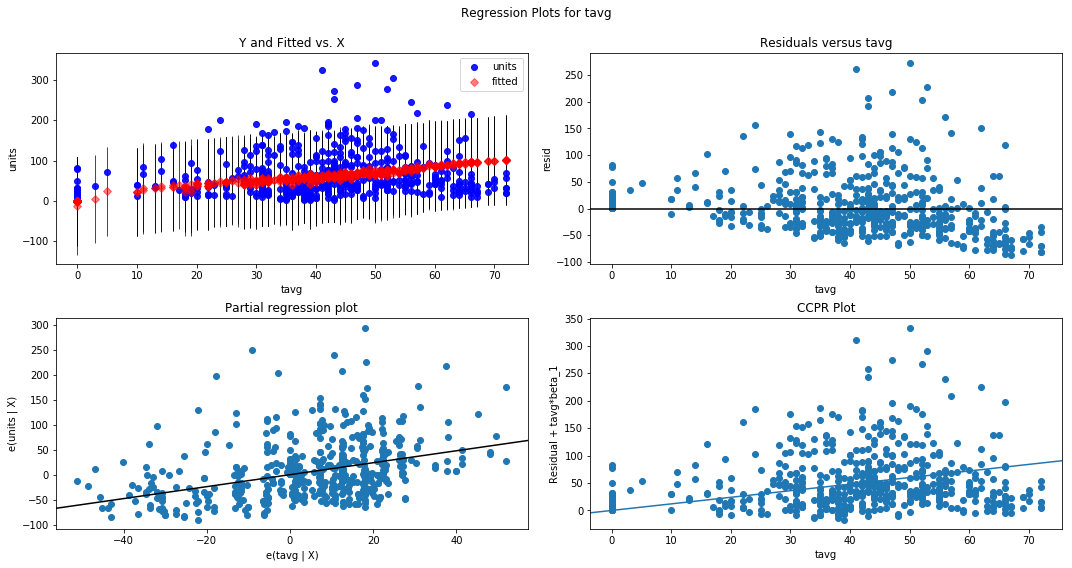

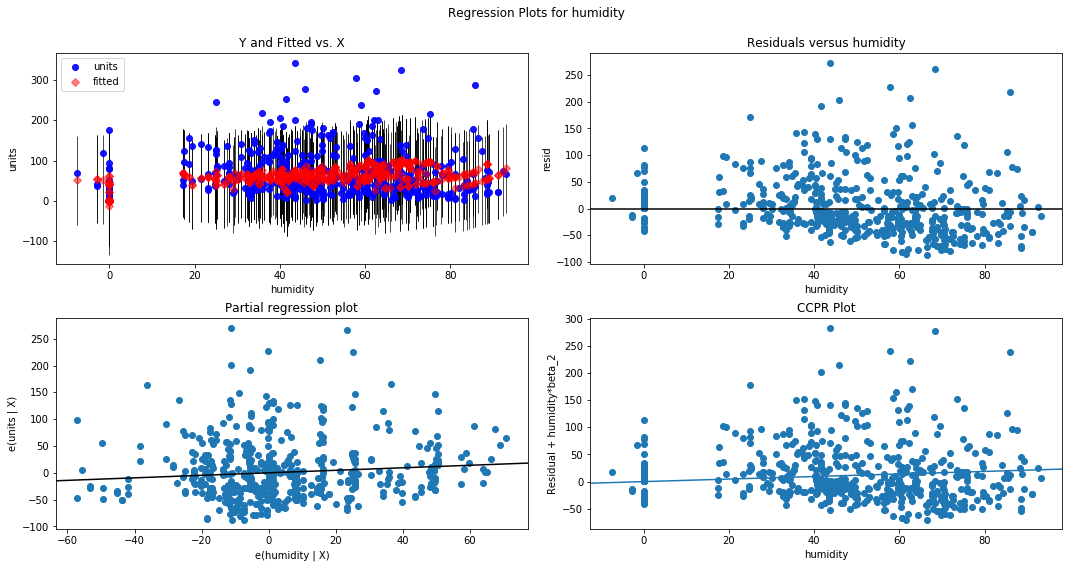

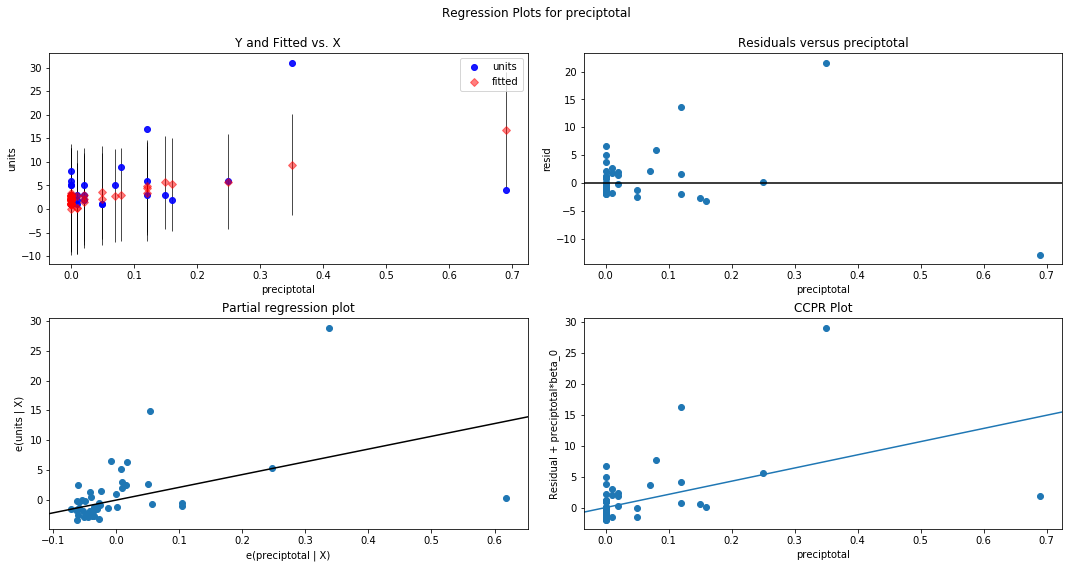

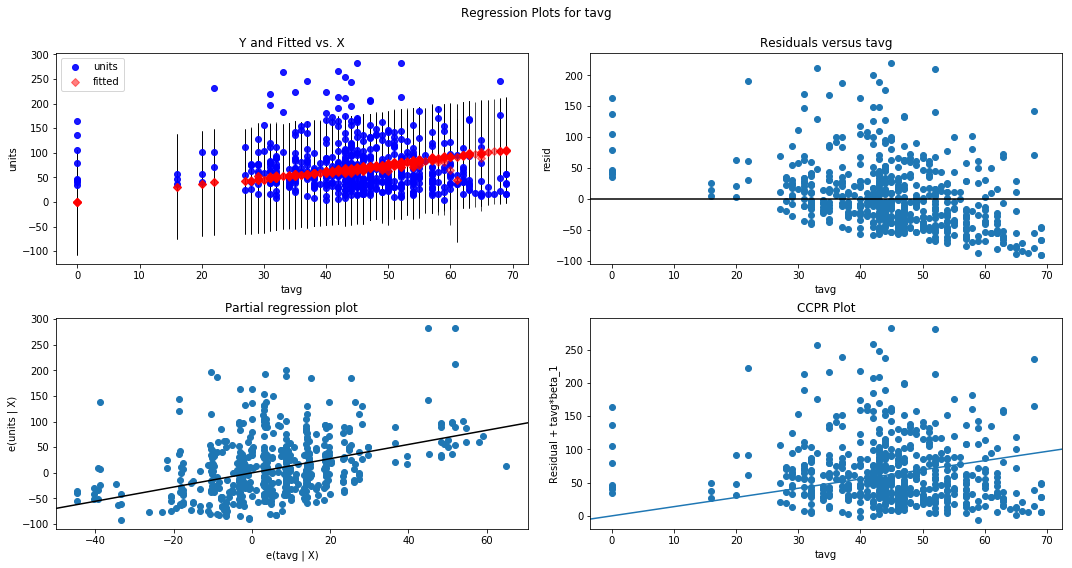

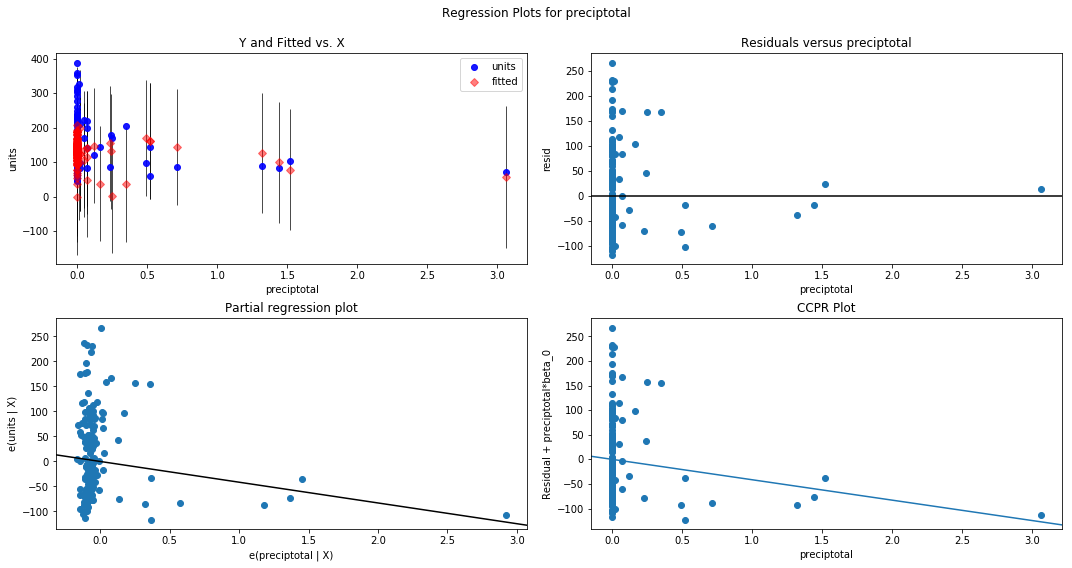

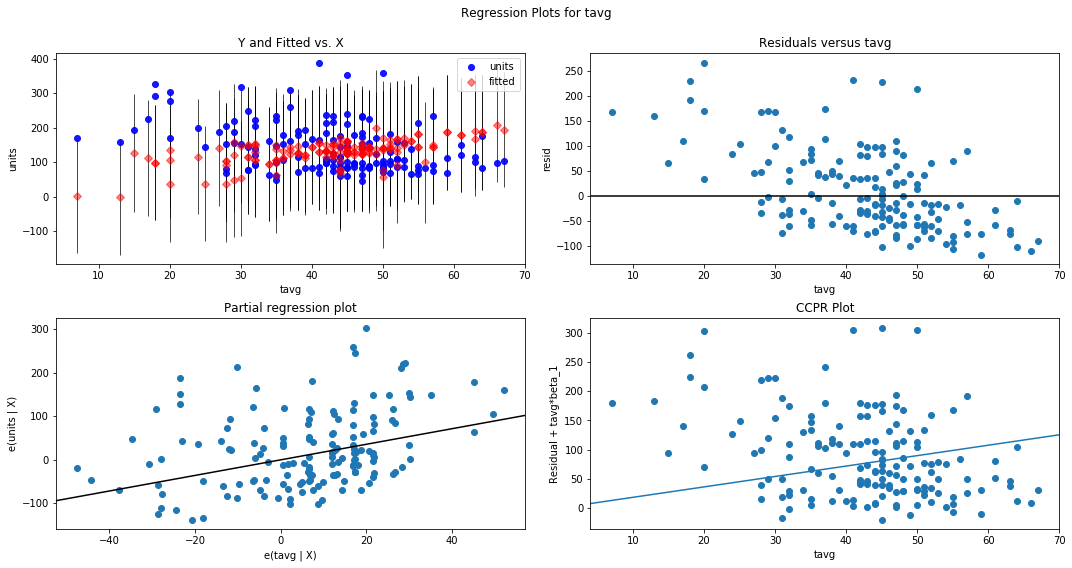

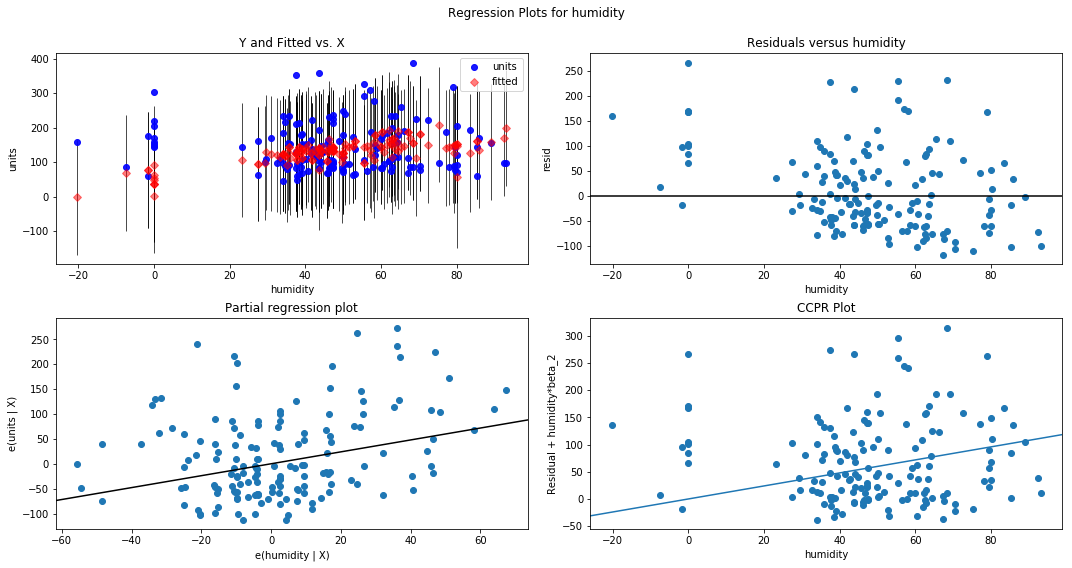

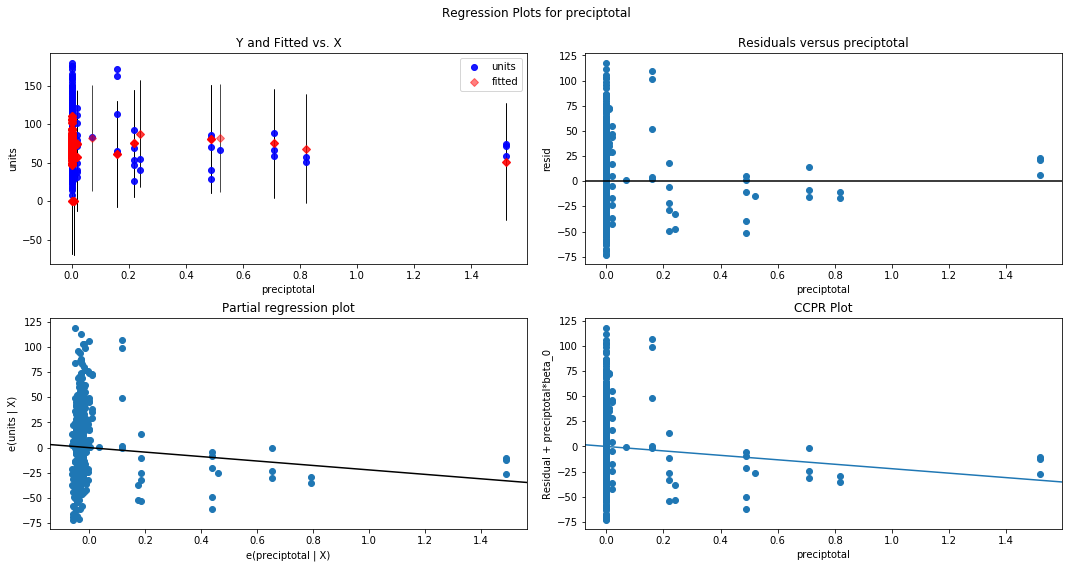

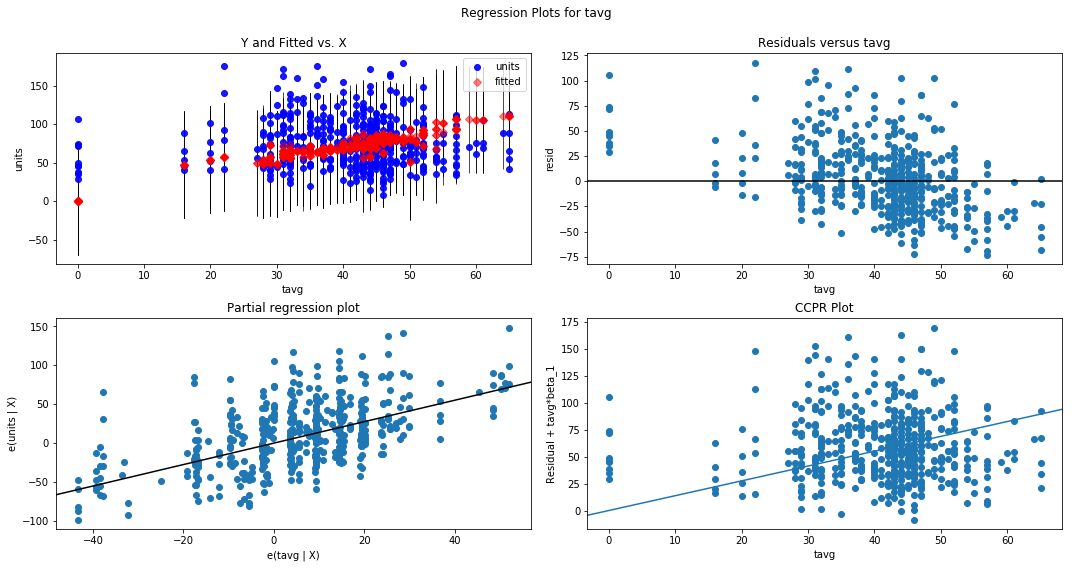

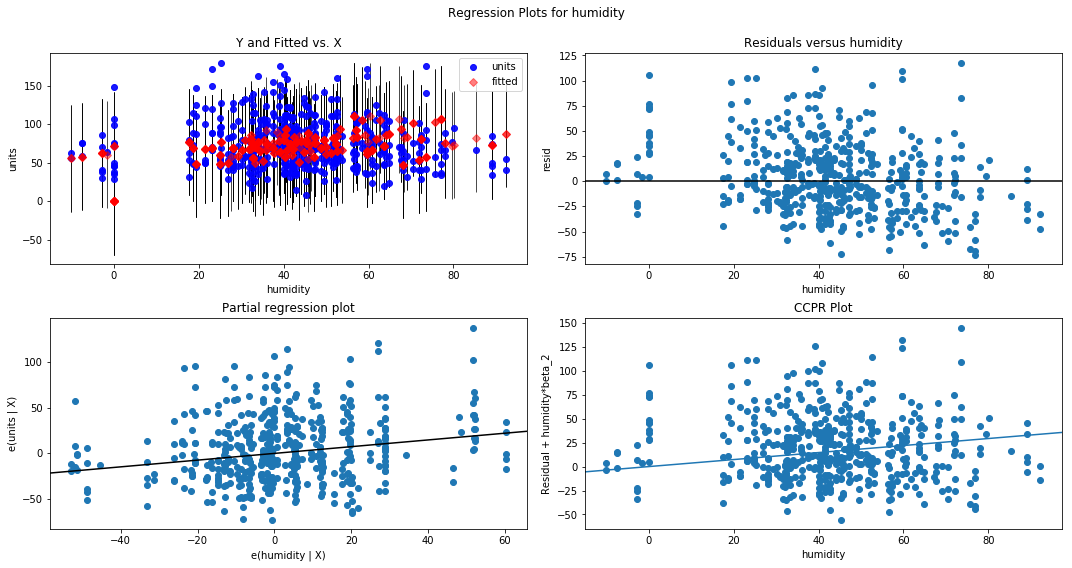

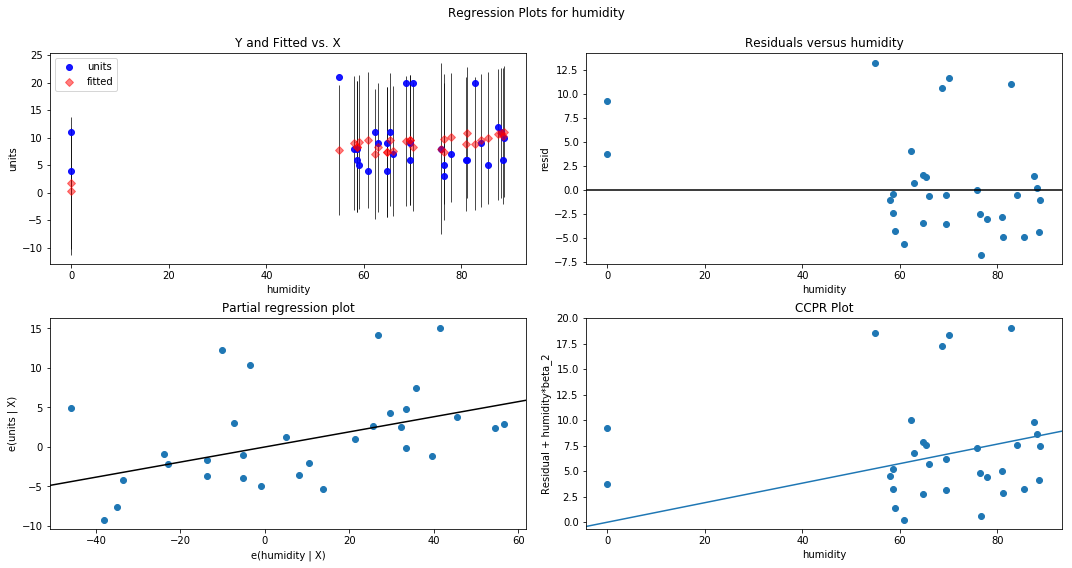

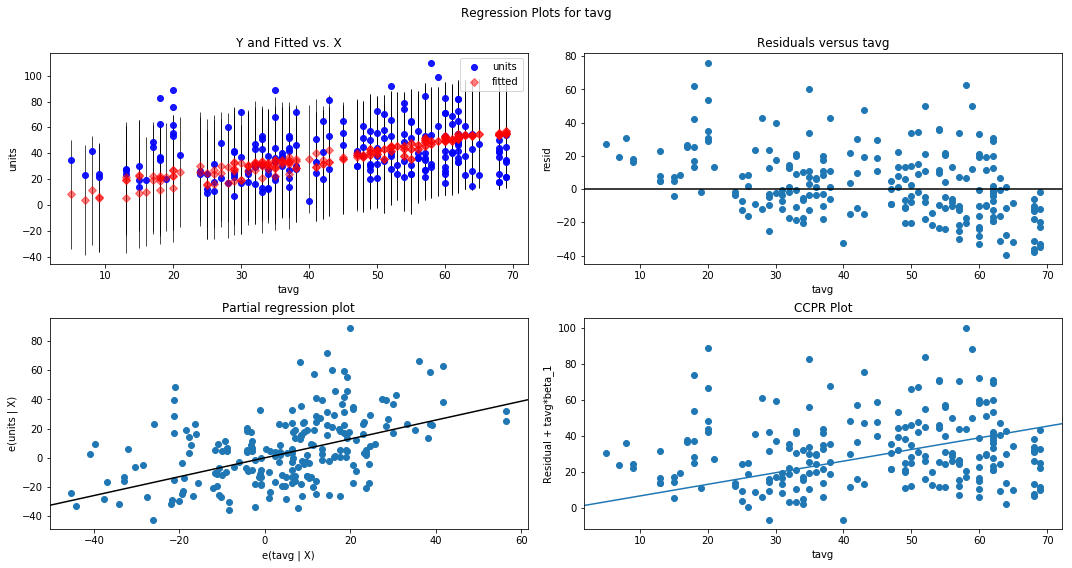

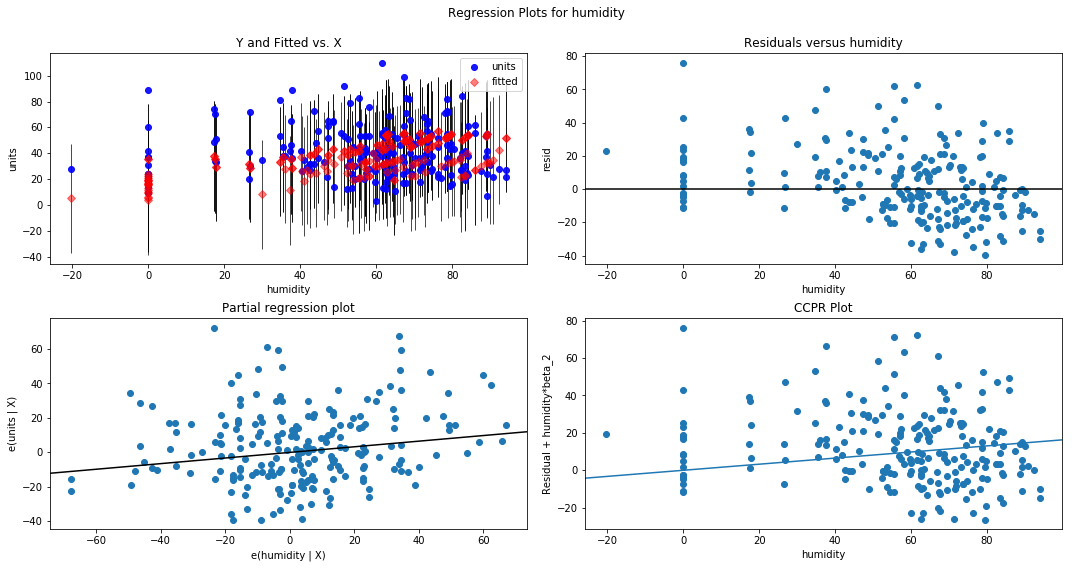

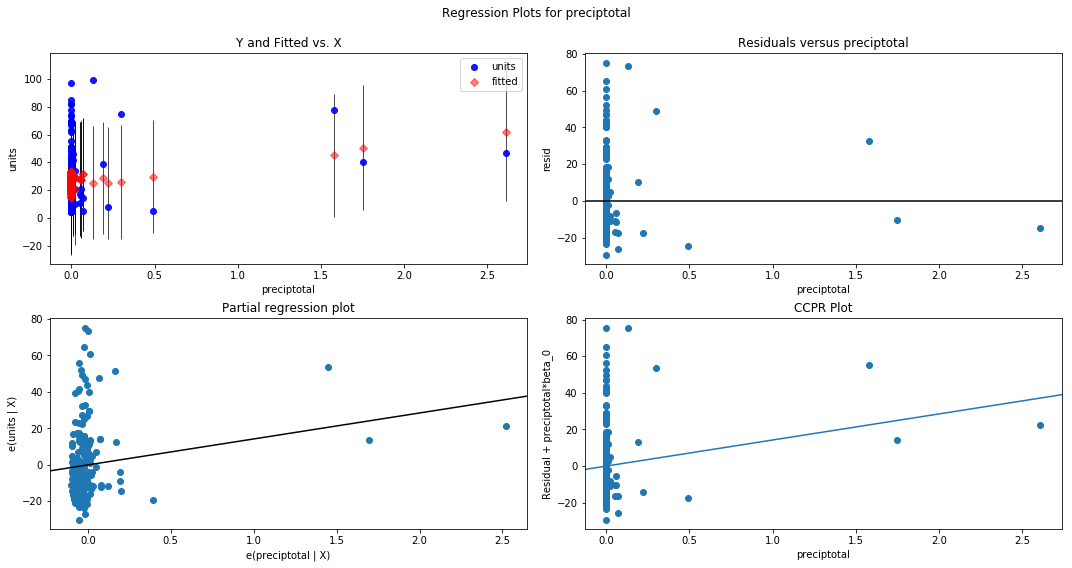

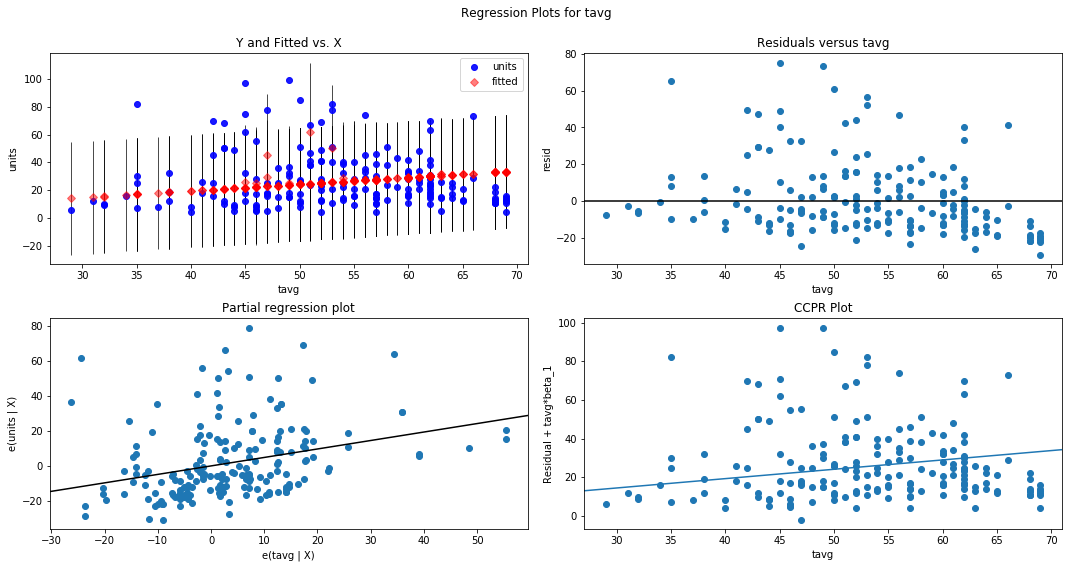

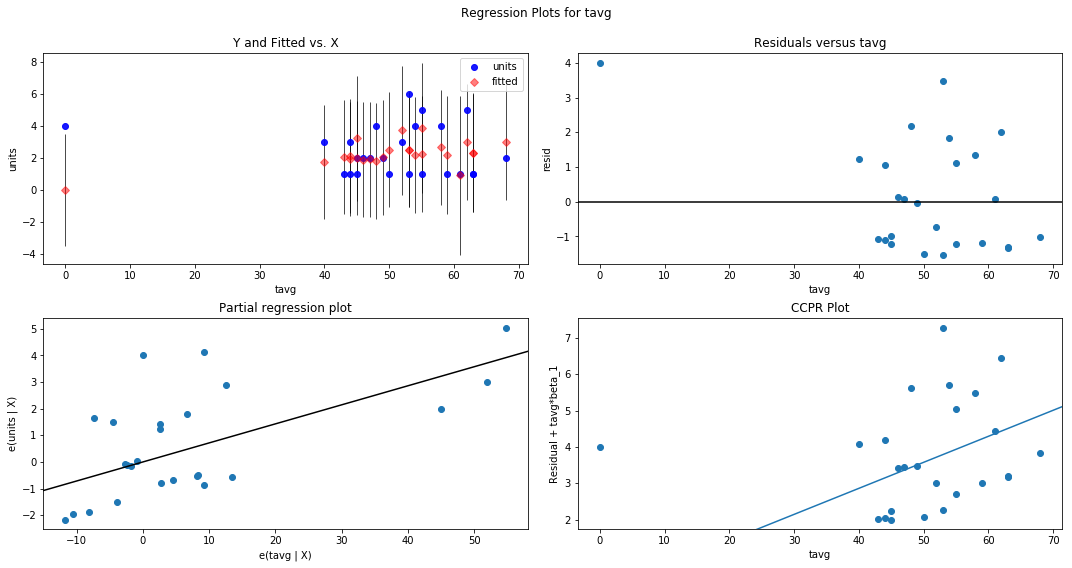

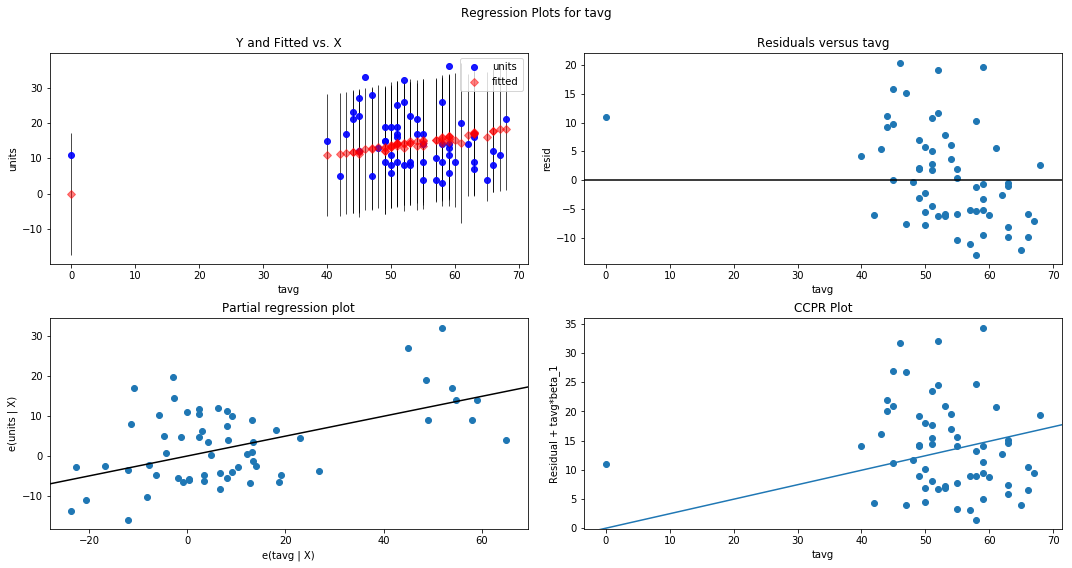

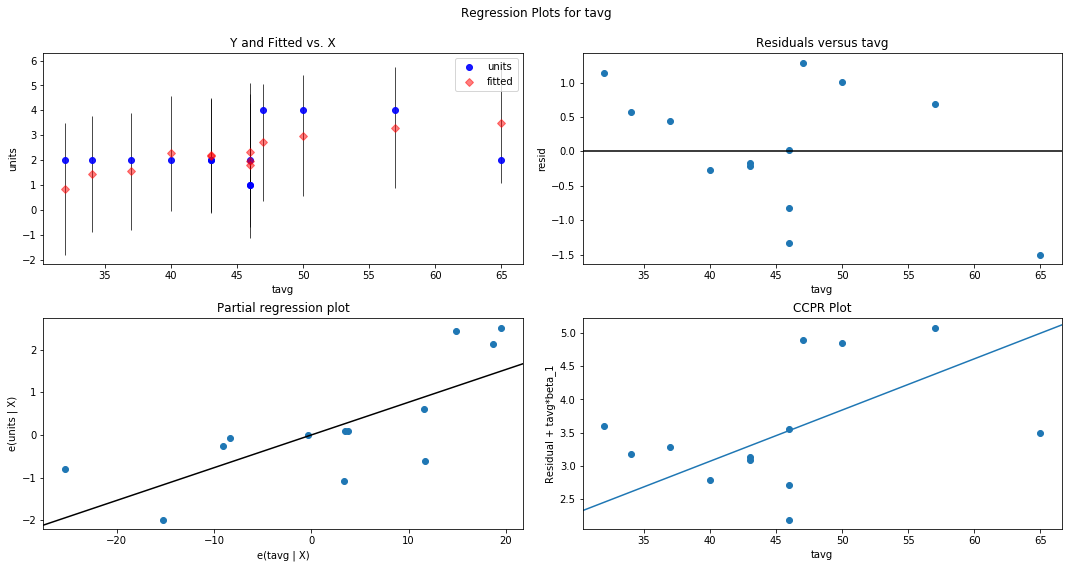

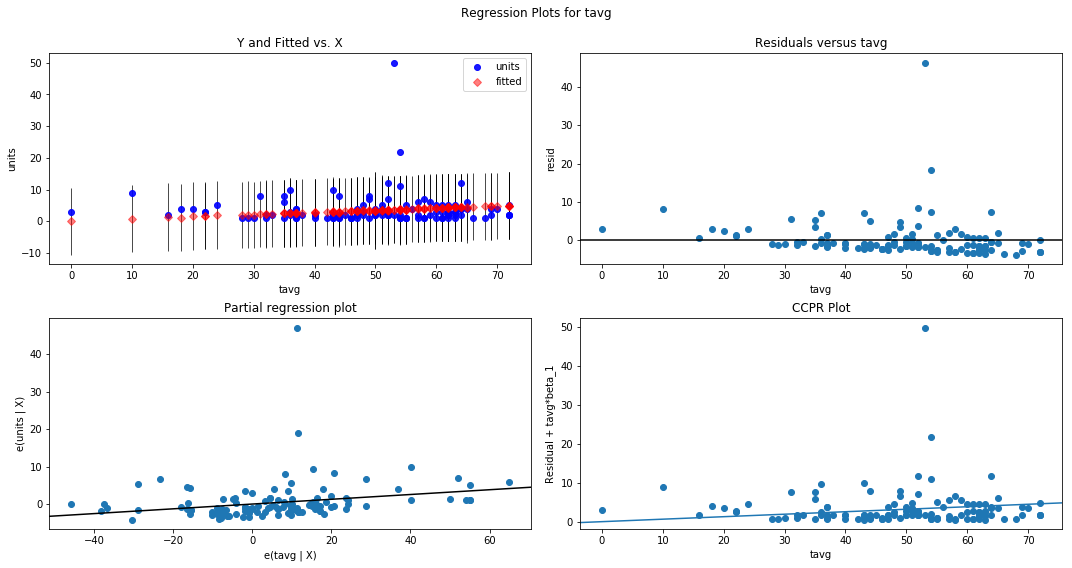

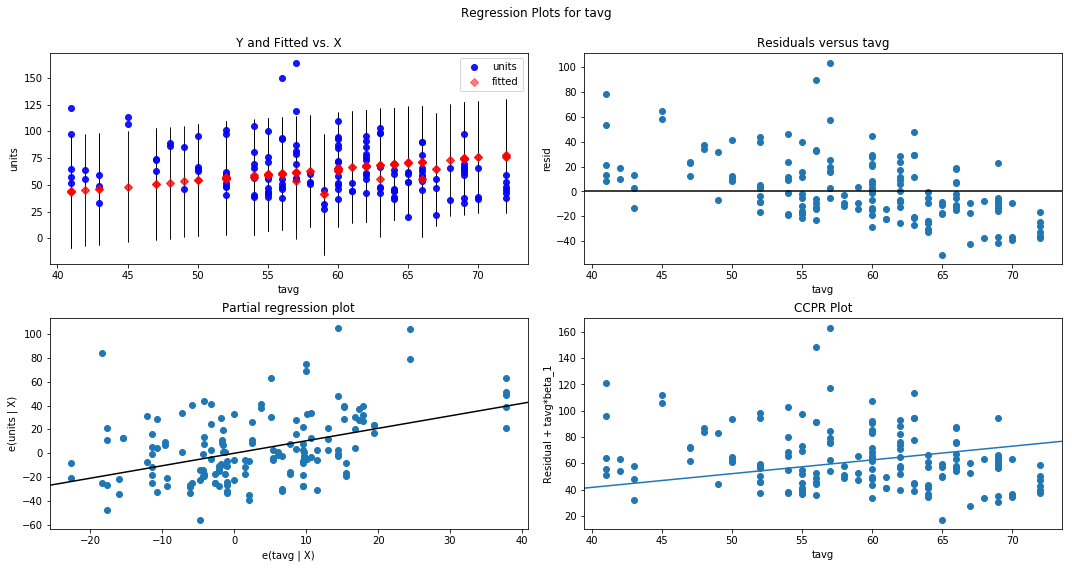

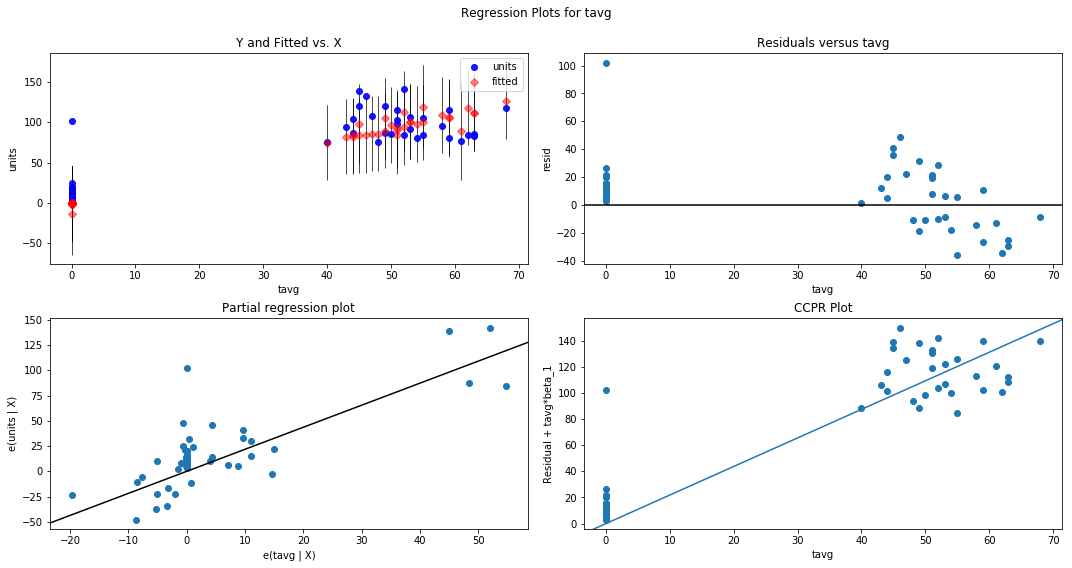

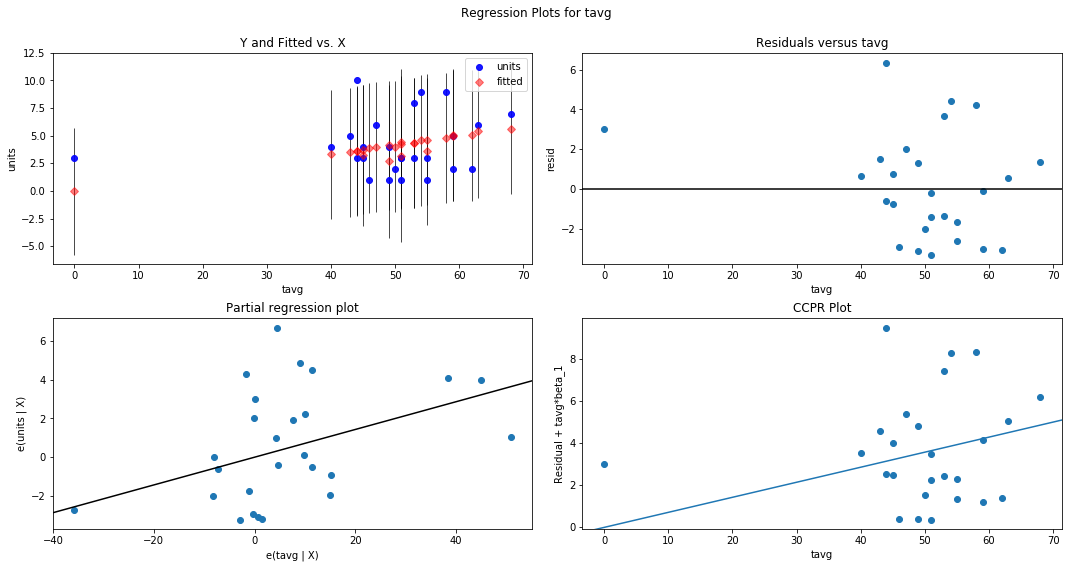

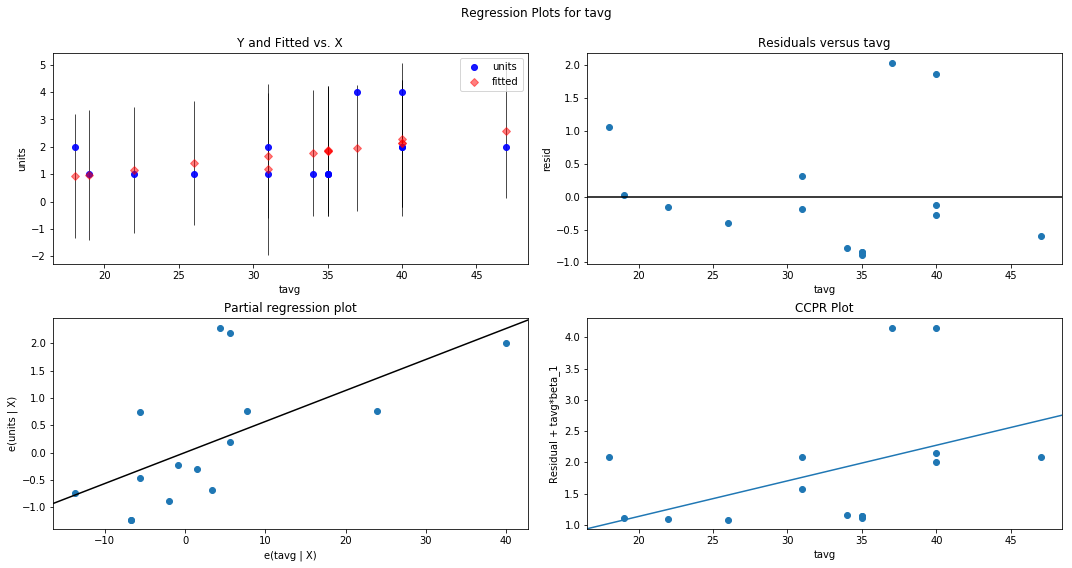

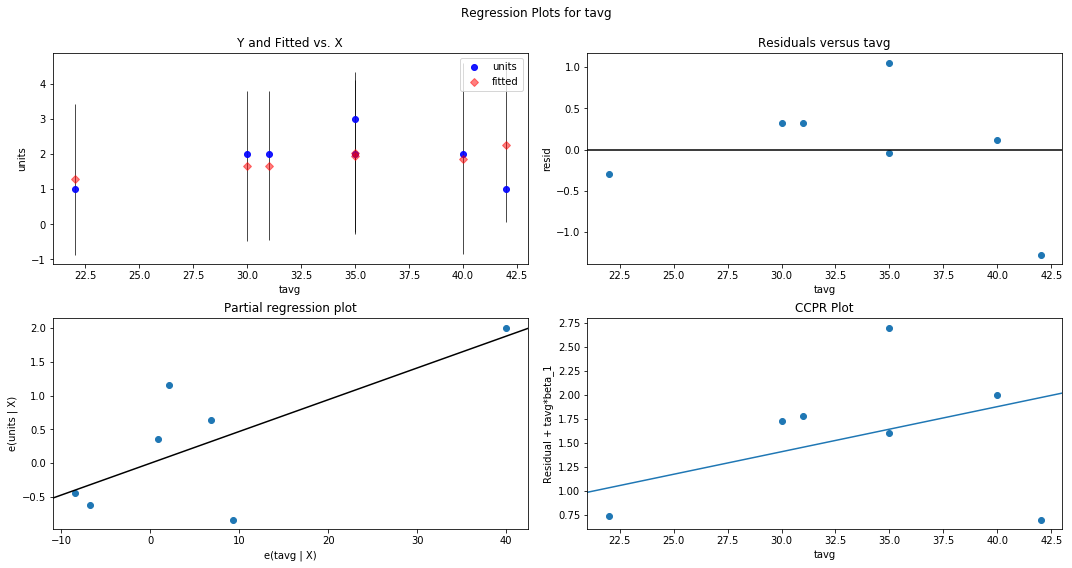

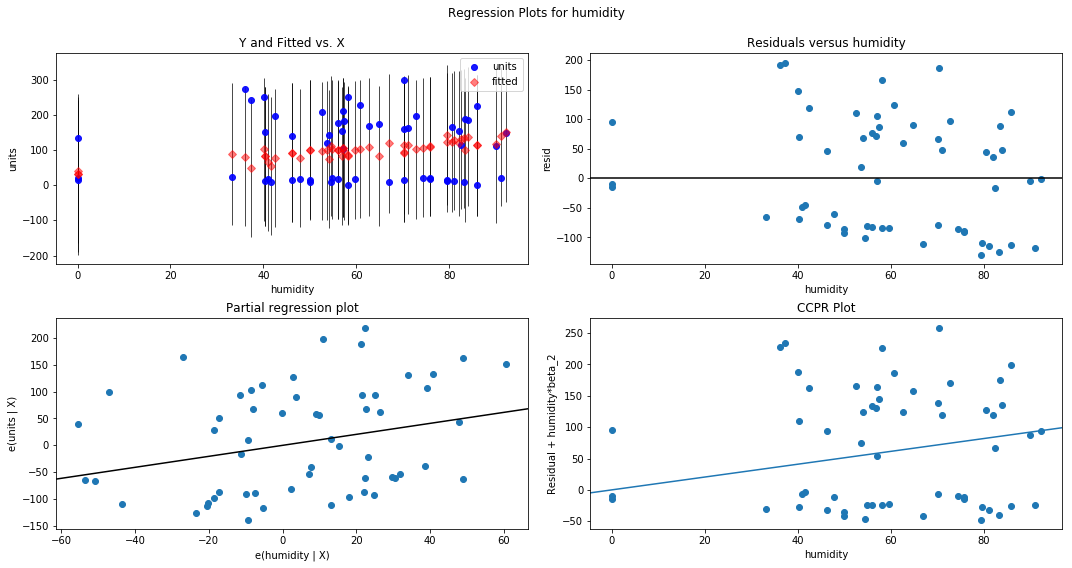

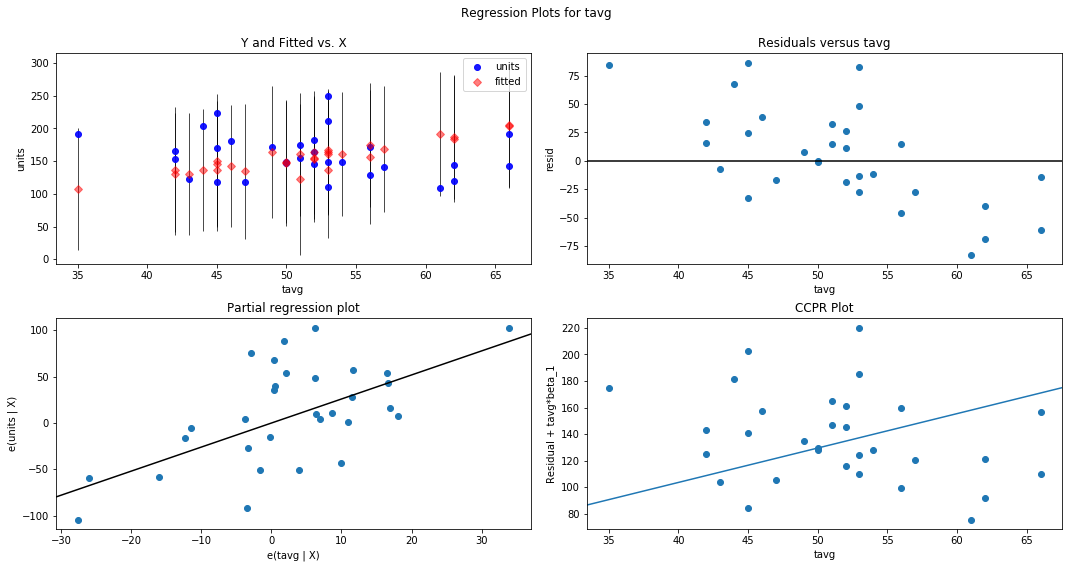

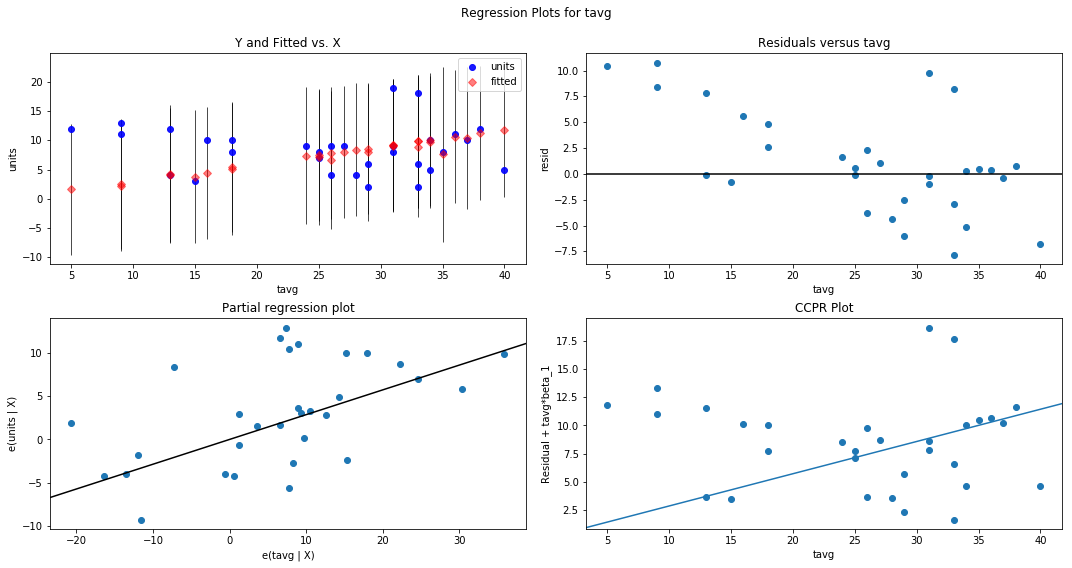

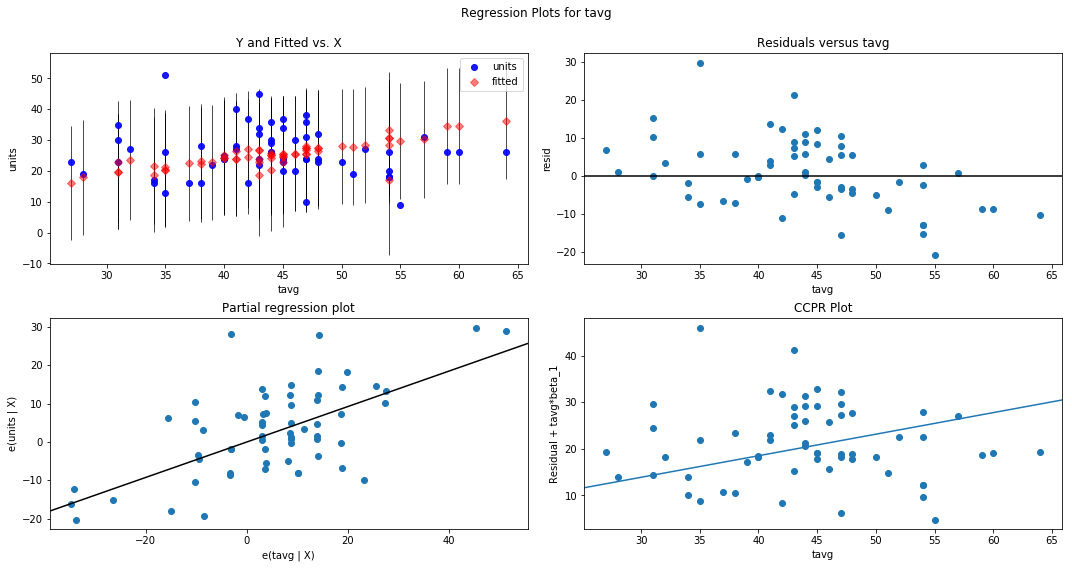

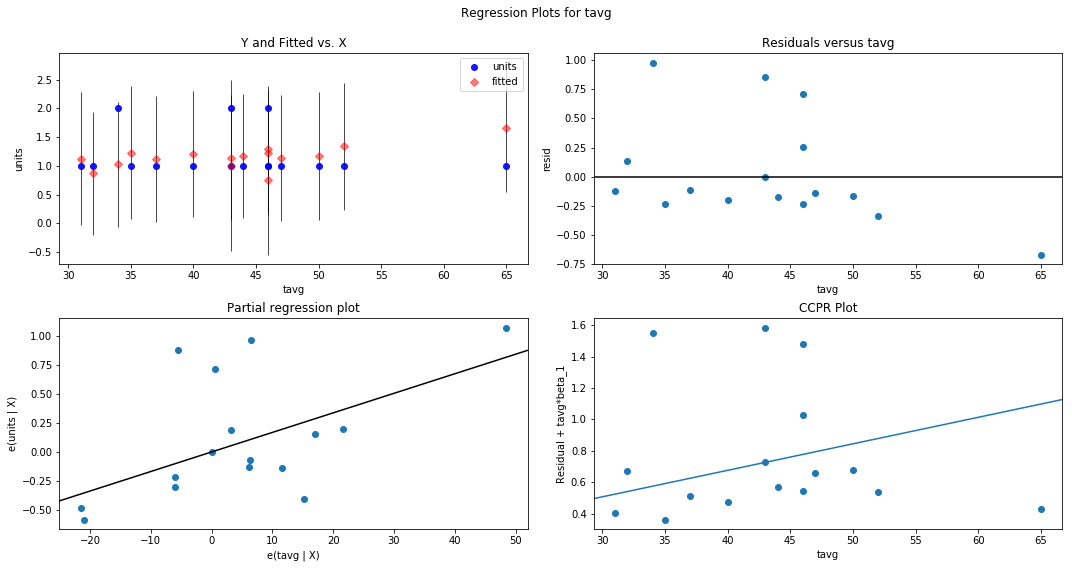

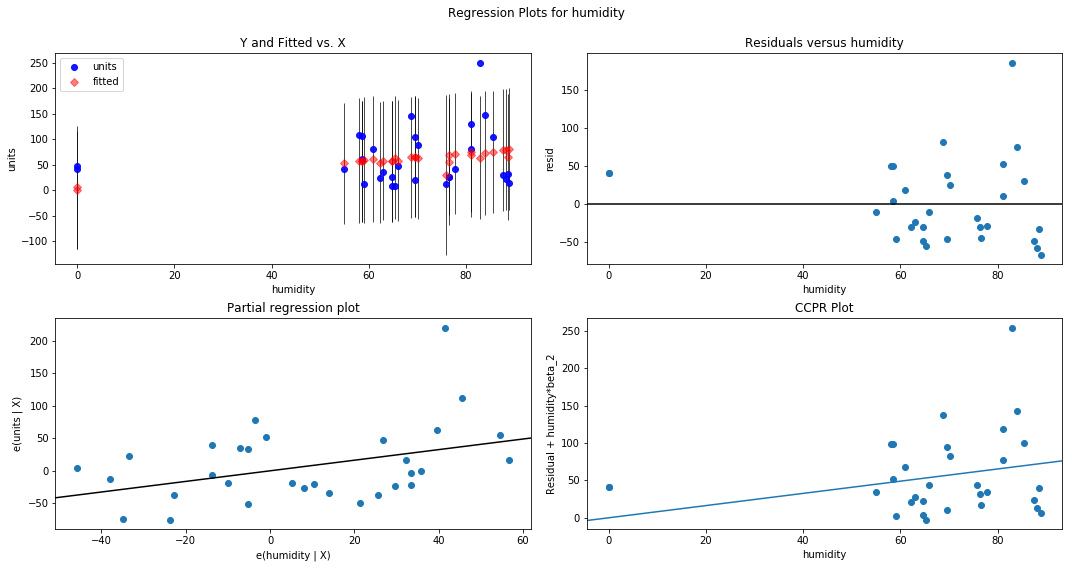

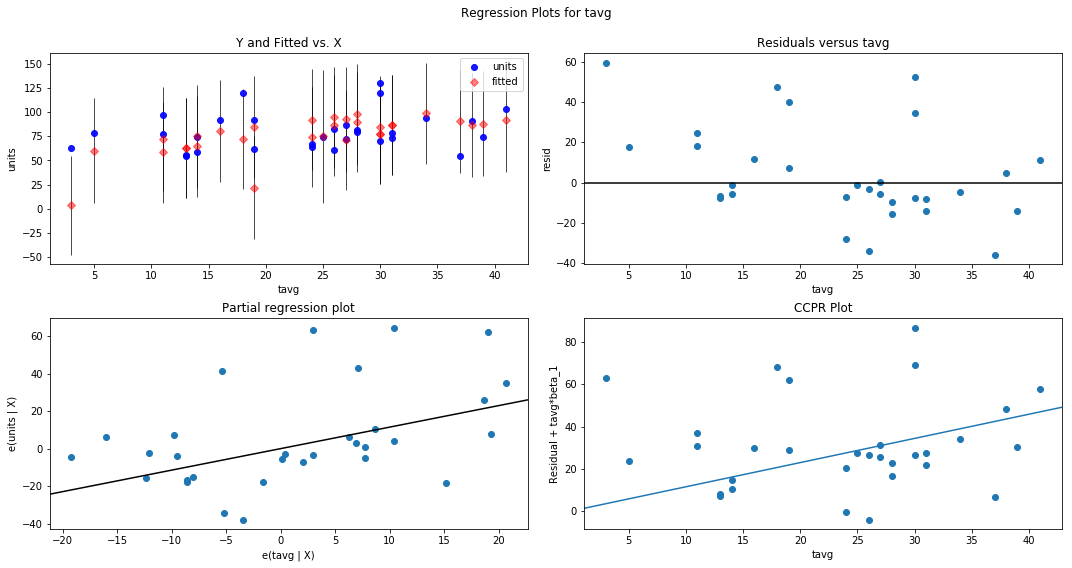

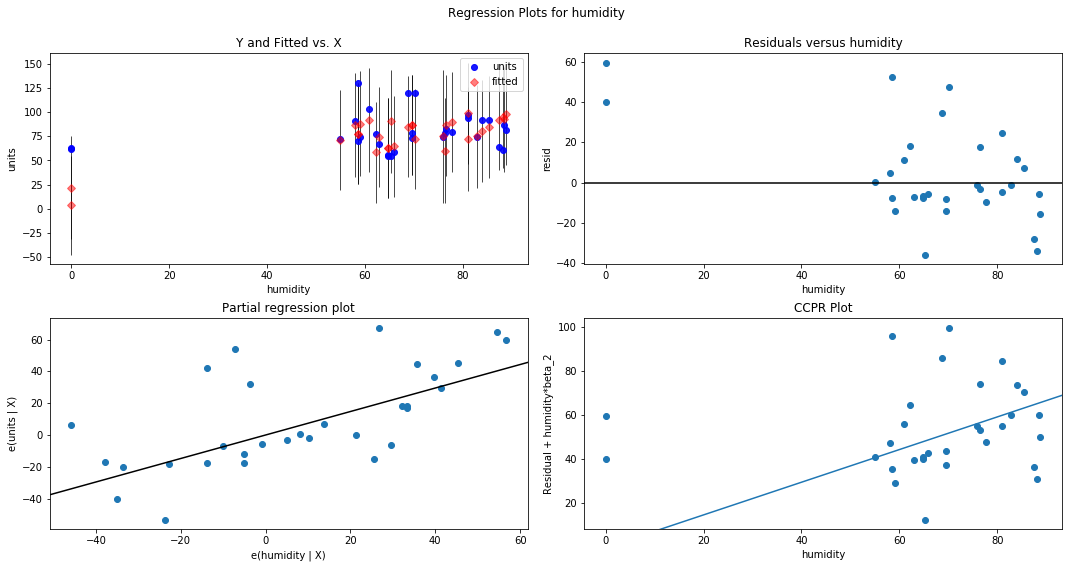

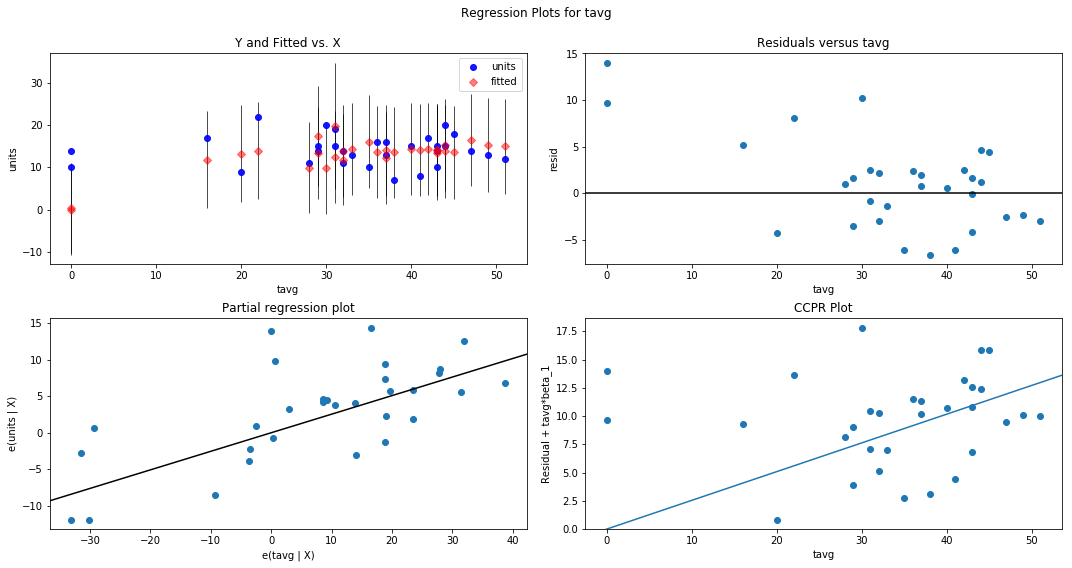

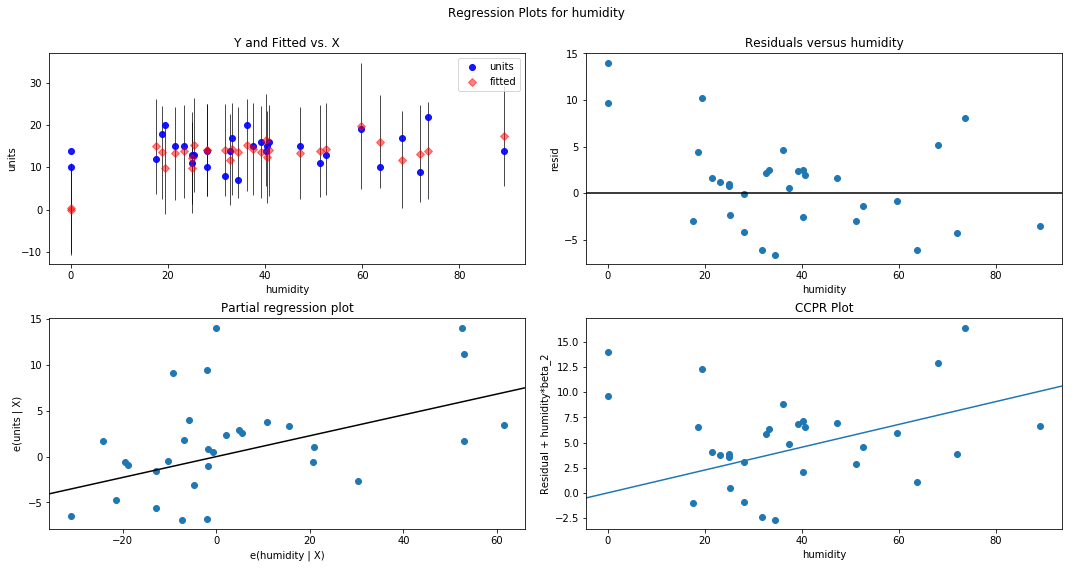

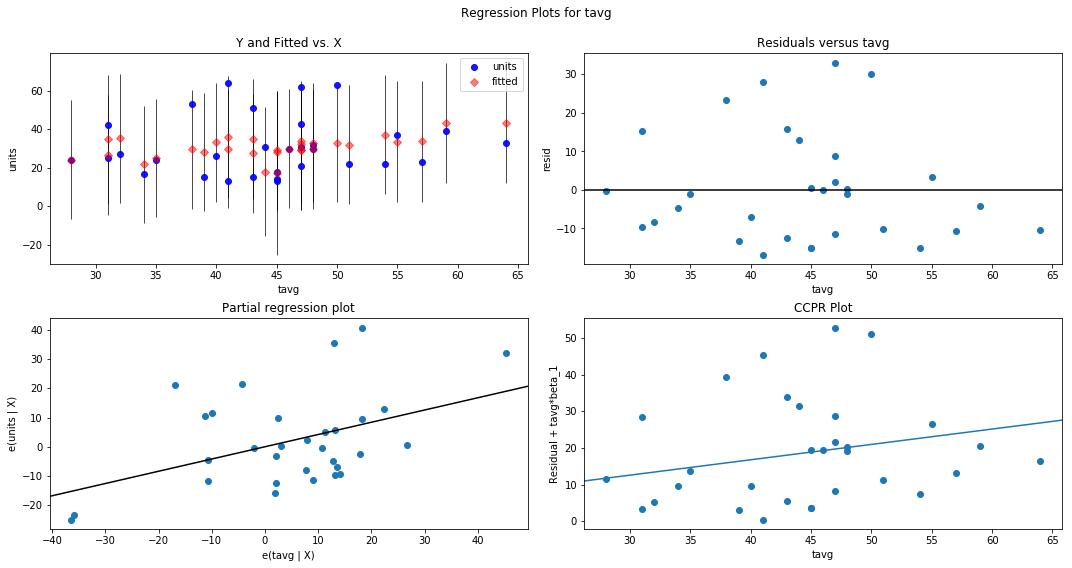

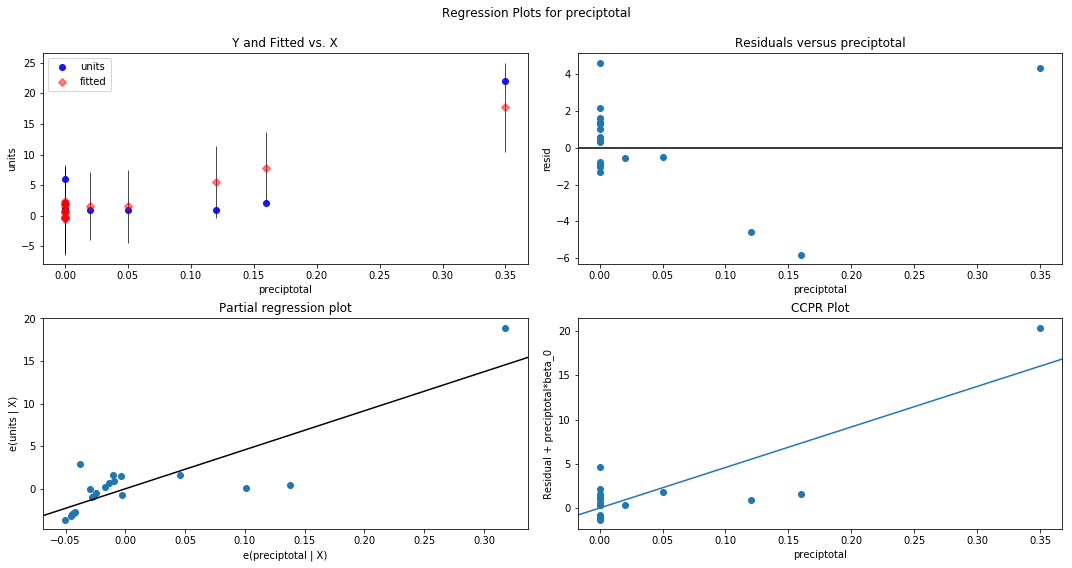

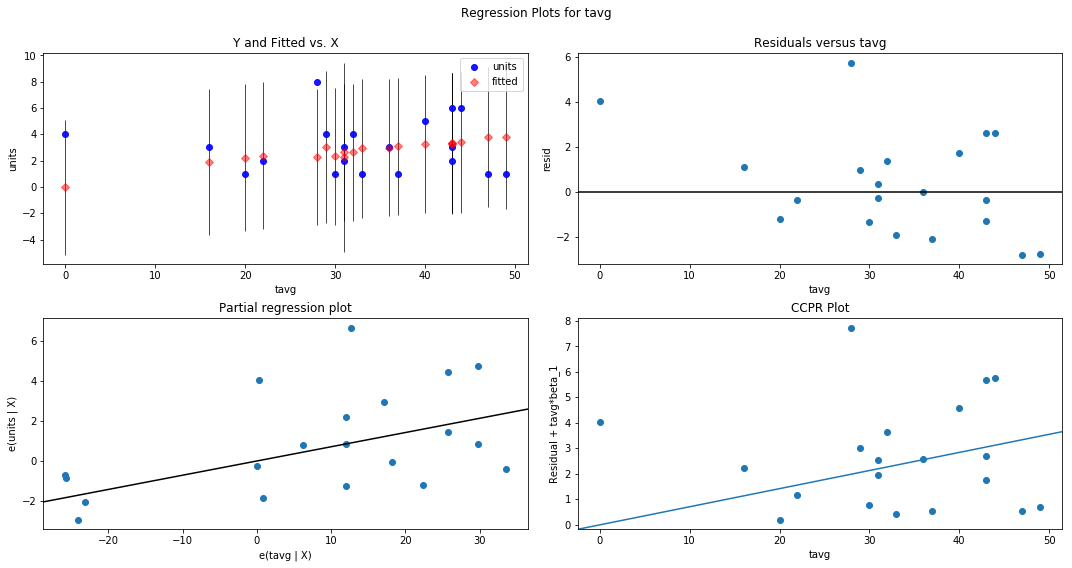

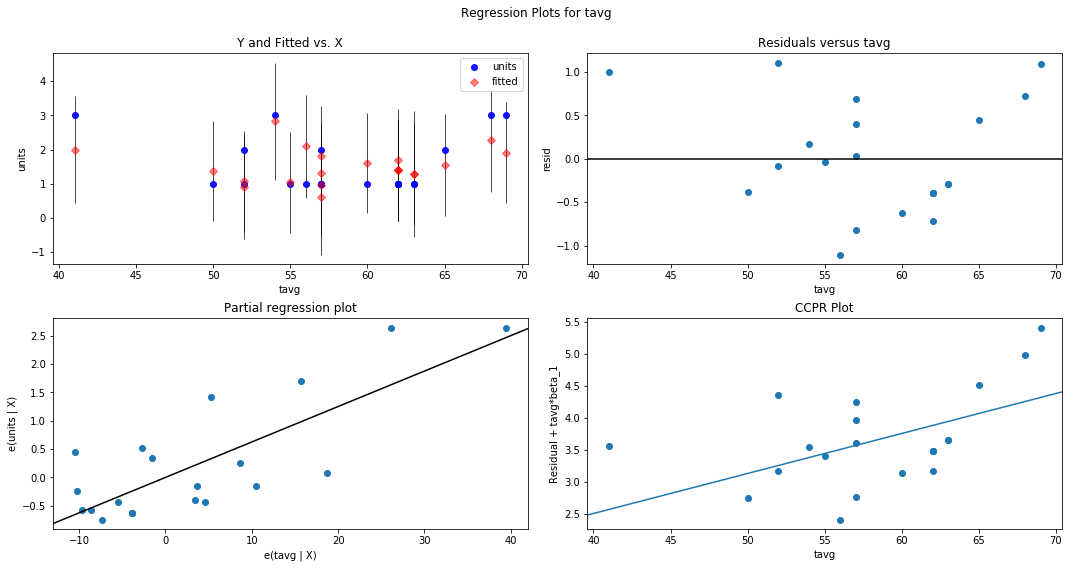

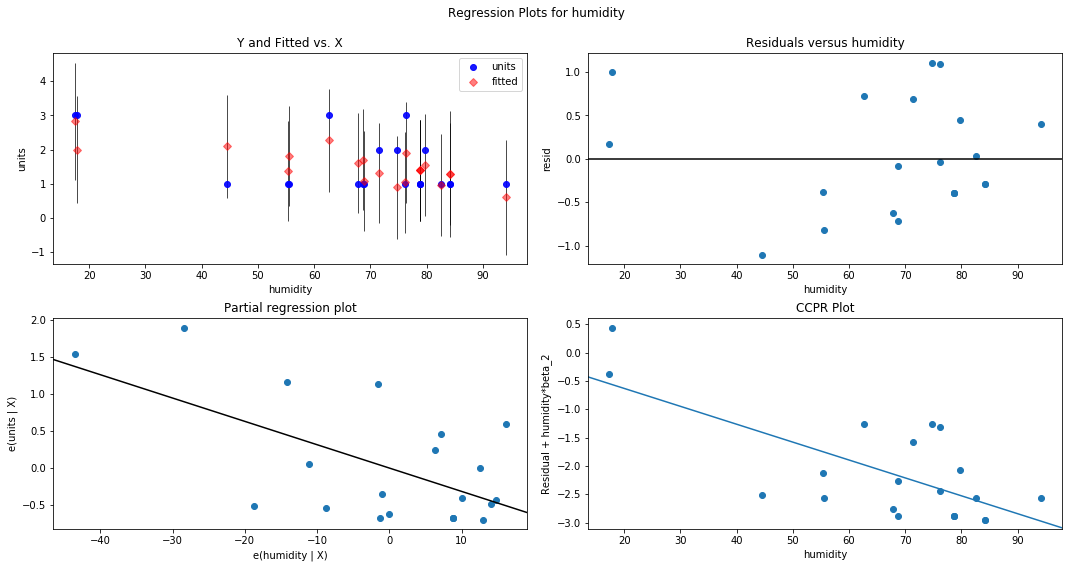

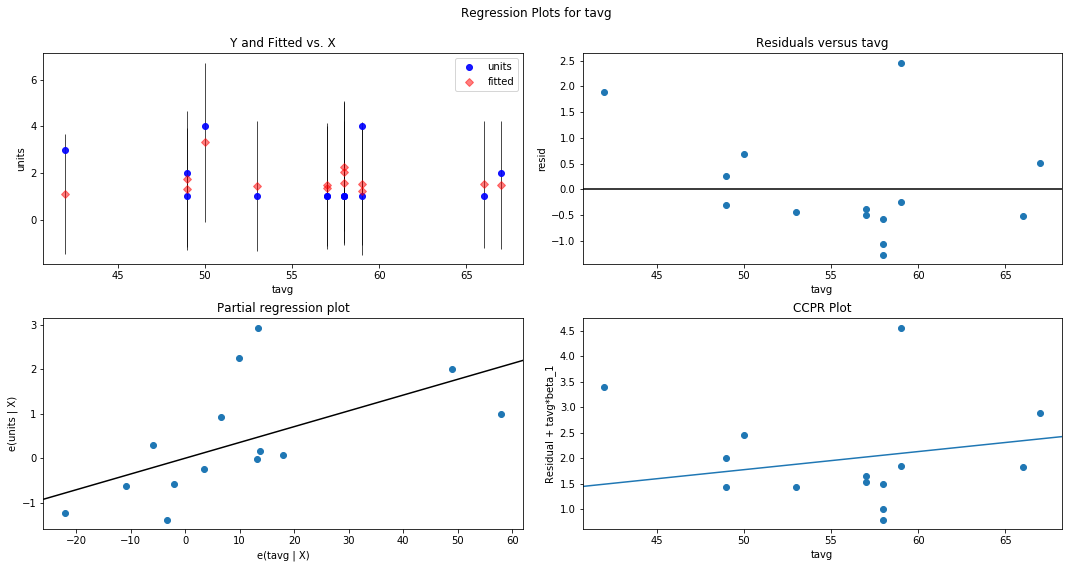

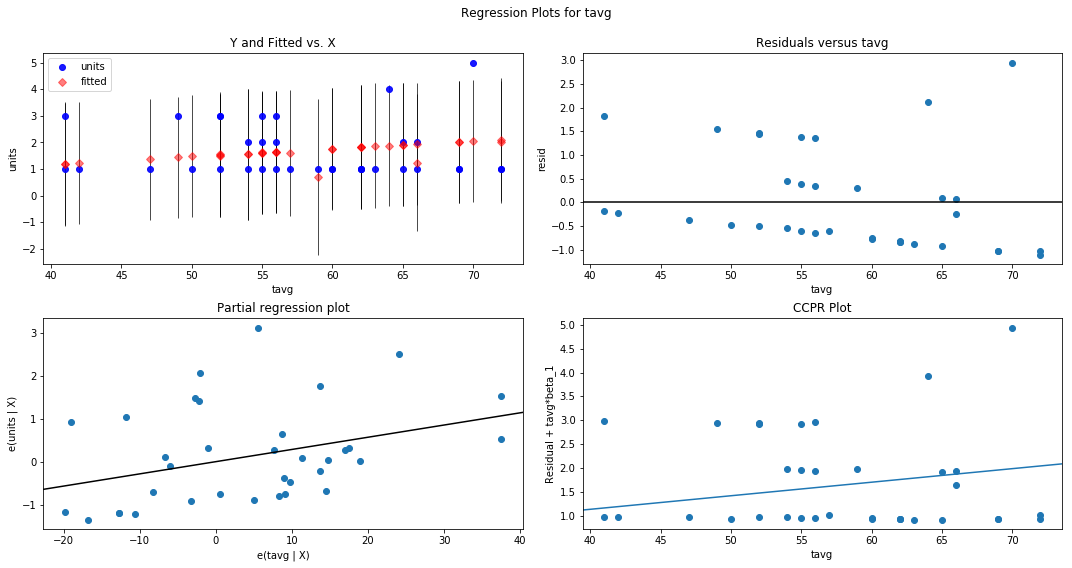

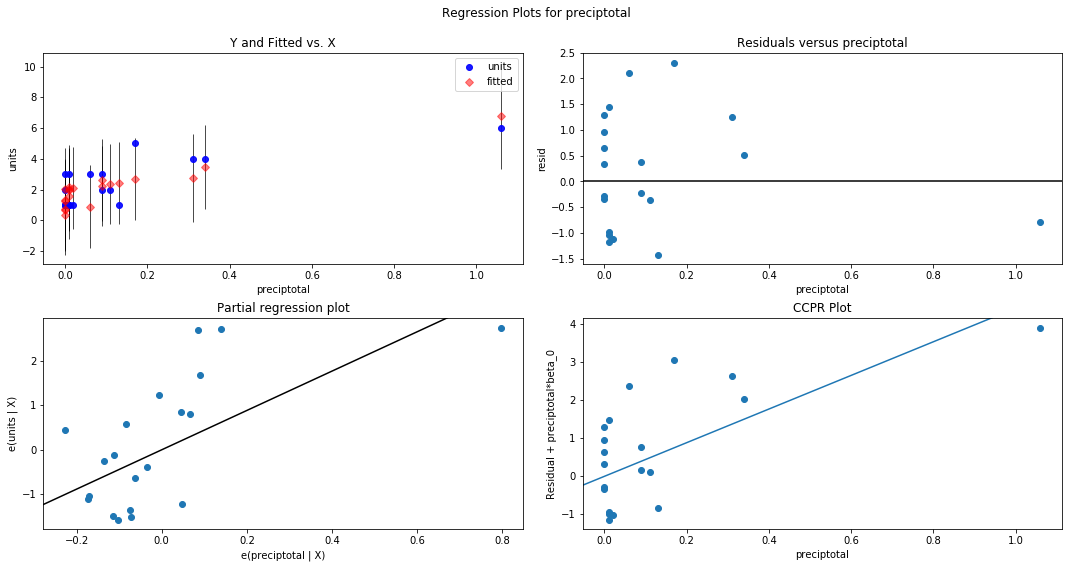

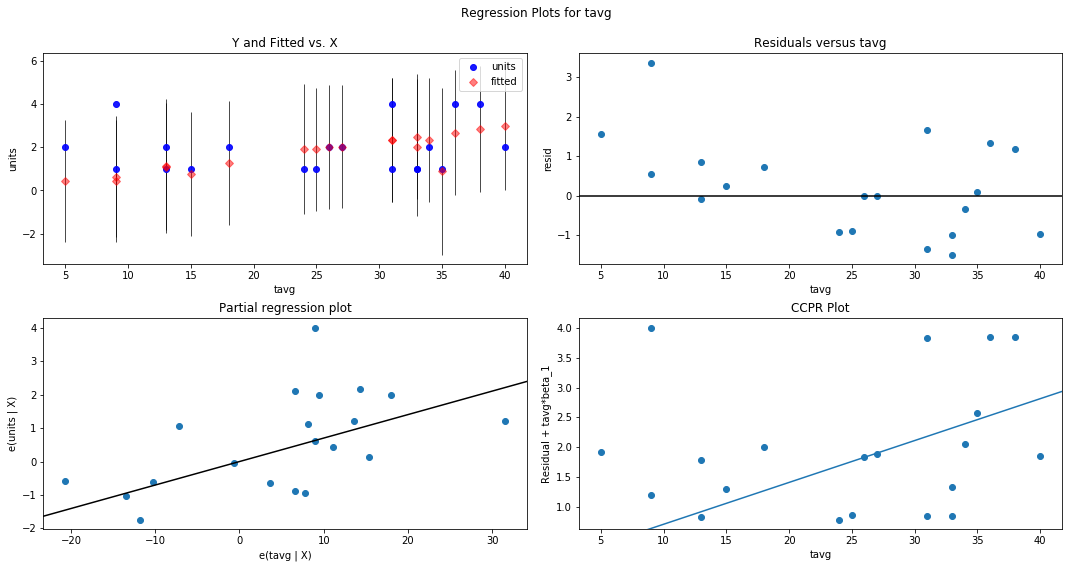

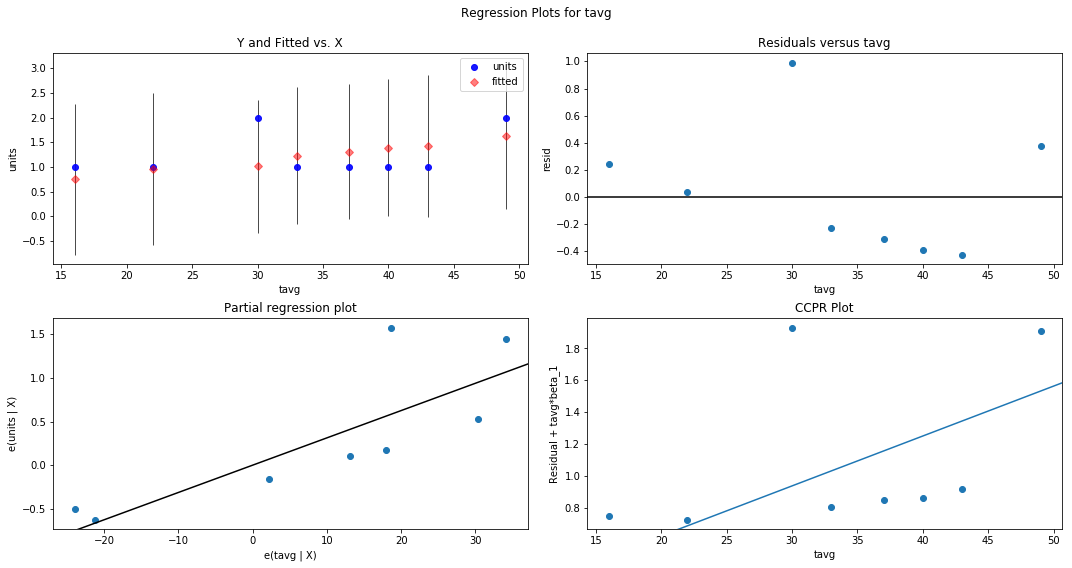

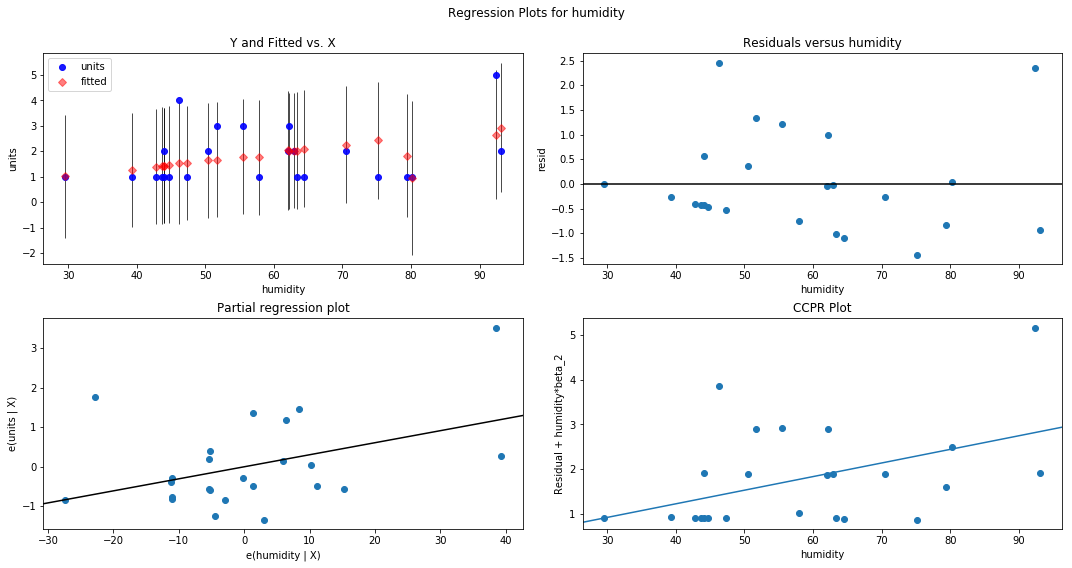

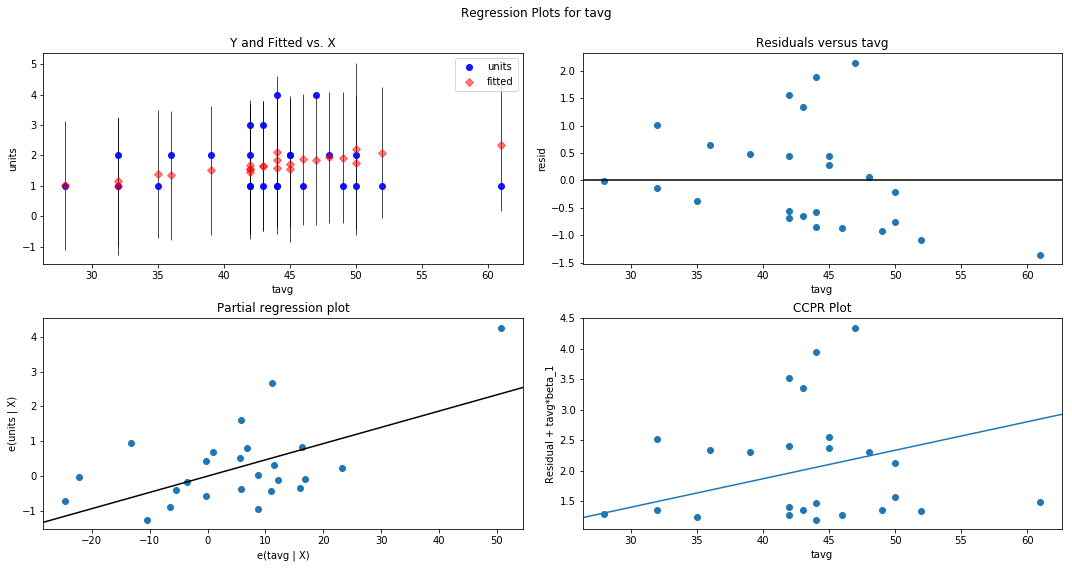

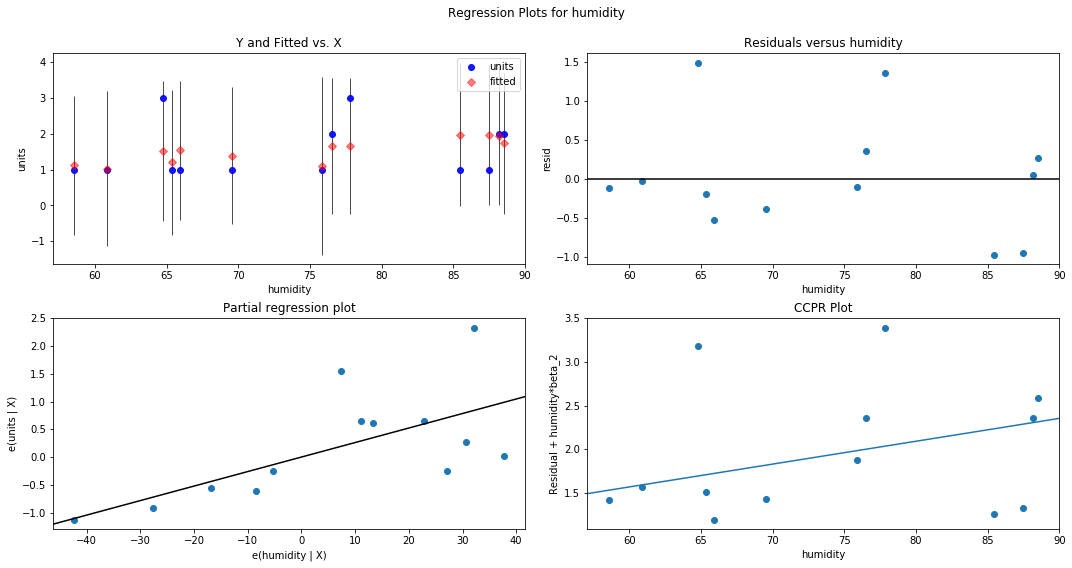

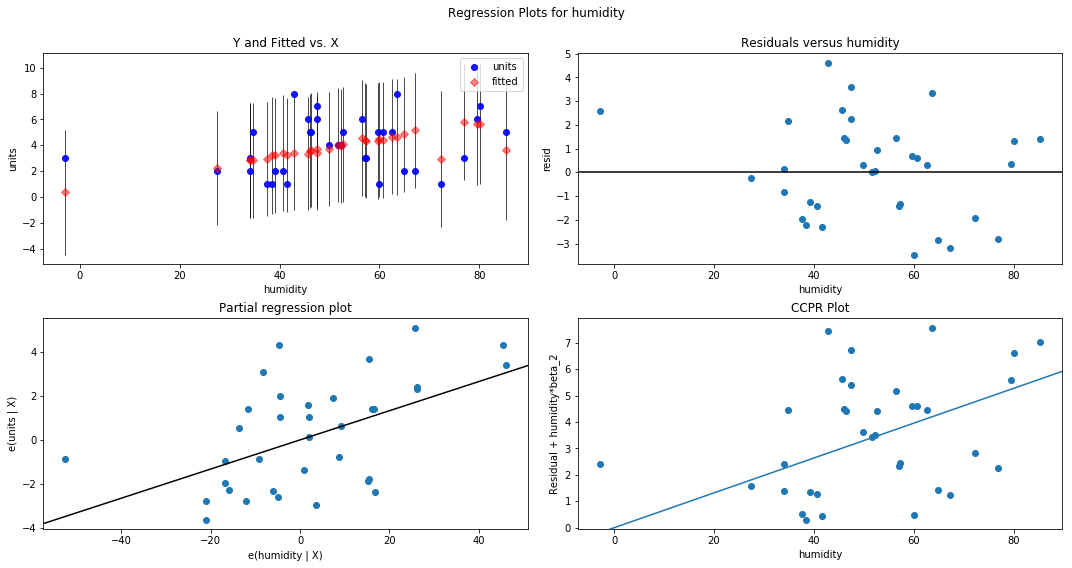

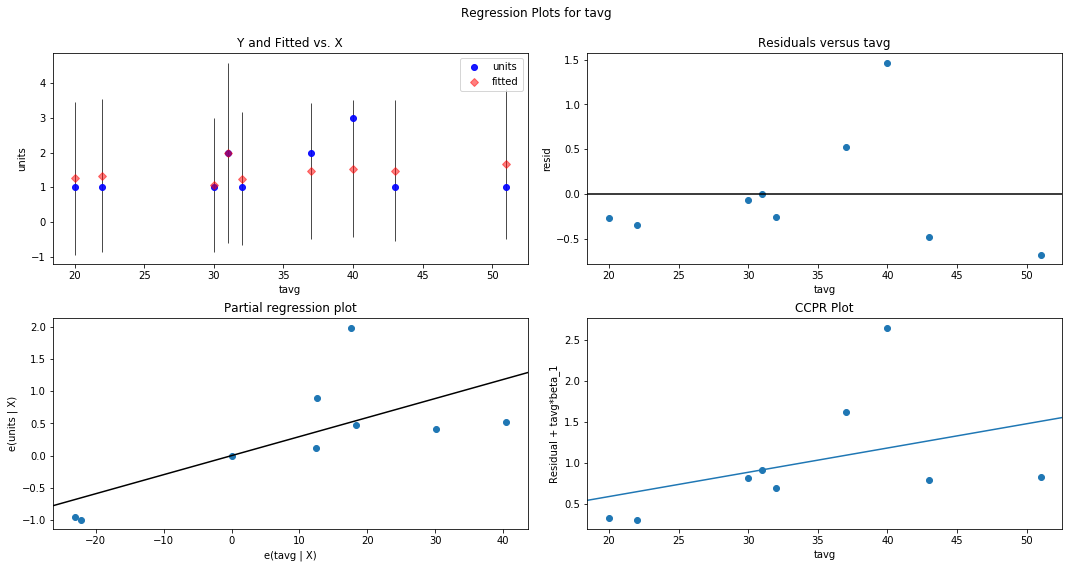

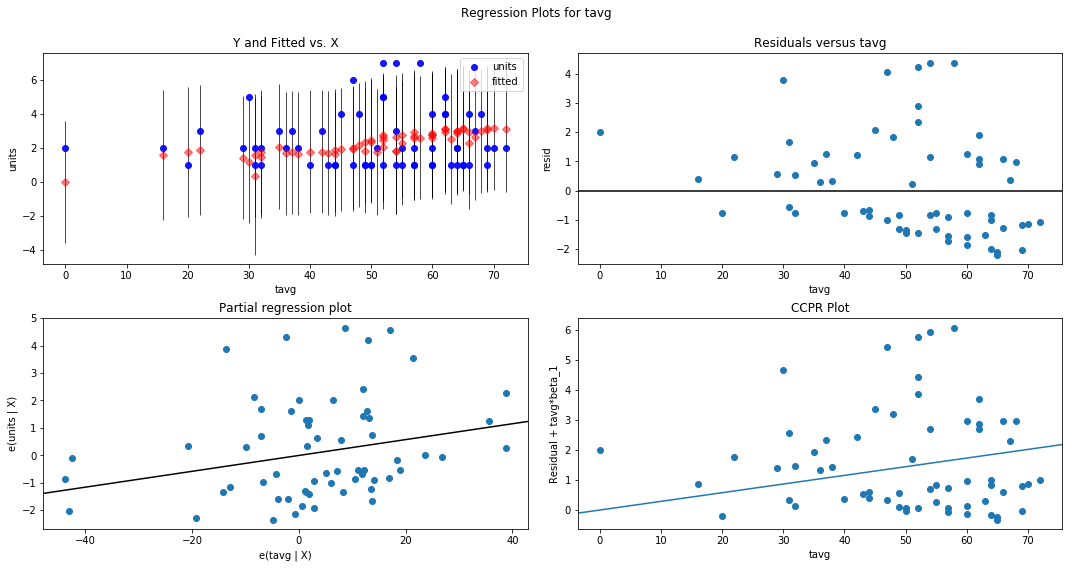

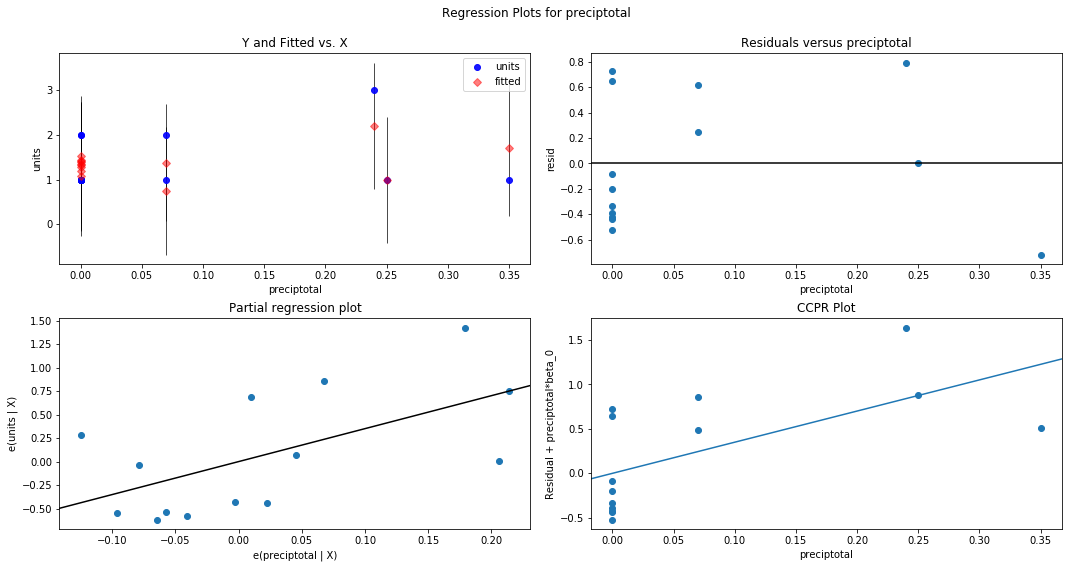

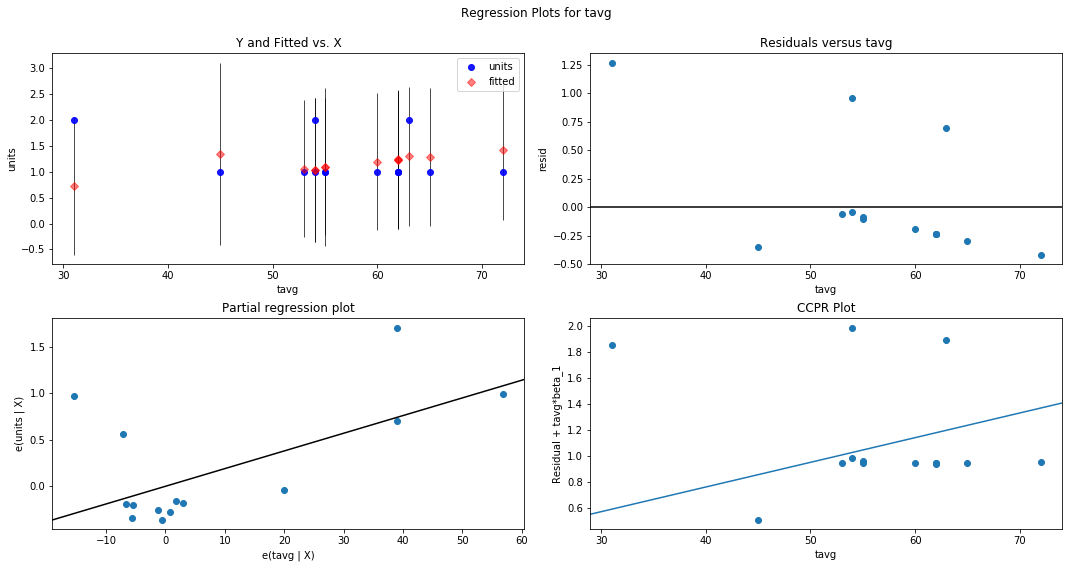

In [9]:
for summary_tuple in significant_columns:
    column_model = summary_tuple[3]
    column_name = summary_tuple[1]
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(column_model, column_name, fig=fig)

# Correlation

## <font color=grey>Overall Item Sales</font>

In [10]:
# why overall and not per store? Reason: https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather/discussion/13233
high_correlation = []

for item_id in items:
    df_reg = df_new[df_new['item_nbr'] == item_id]
    if df_reg.shape[0] > 0:
        df_reg.fillna(0, inplace=True)
        # feature_columns = ['snowfall', 'preciptotal', 'tavg', 'tmin', 'tmax', 'humidity', 'avgspeed', 'units']
        feature_columns = ['preciptotal', 'tavg', 'humidity', 'units']
        corr_df = df_reg[feature_columns]
        corr = corr_df.corr(method='spearman')
        for a in feature_columns:
            for b in feature_columns:
                if (a == 'units') or (b == 'units'):
                    correlation_value = corr[a][b]
                    if (not np.isnan(correlation_value)) and (abs(correlation_value) > constants.HIGH_CORRELATION) and (abs(correlation_value) != 1):
                        summary_tuple = (item_id, a, b, corr)
                        high_correlation.append(summary_tuple)

## <font color=grey>Heatmap</font>

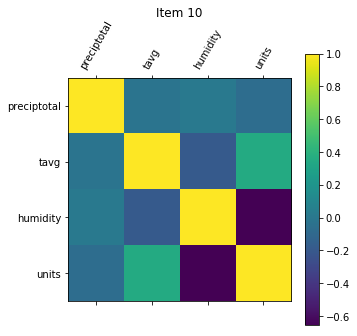

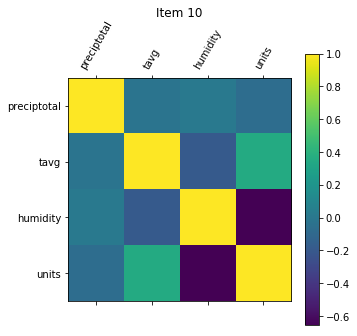

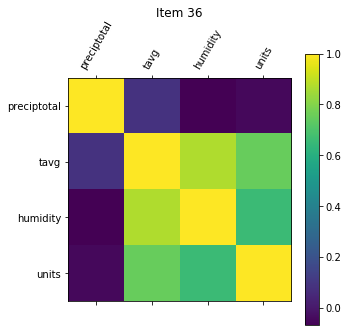

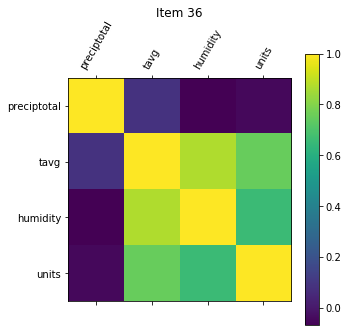

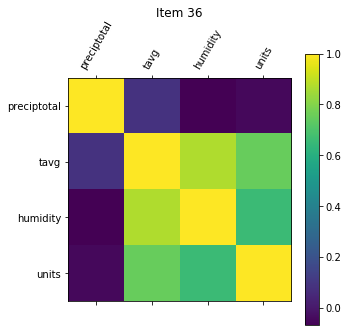

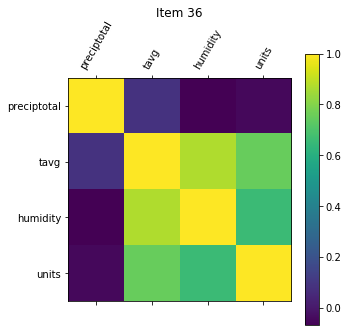

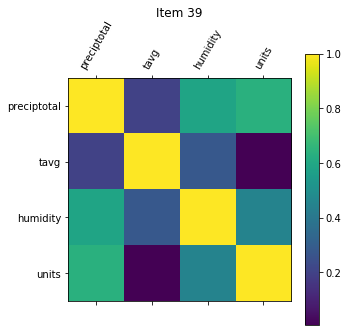

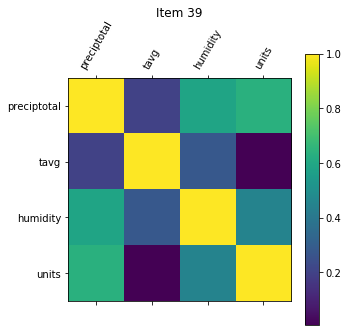

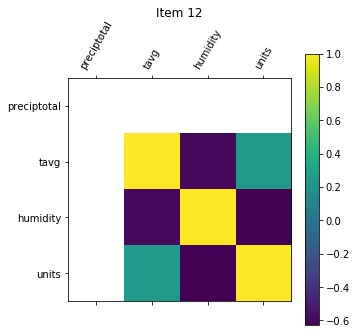

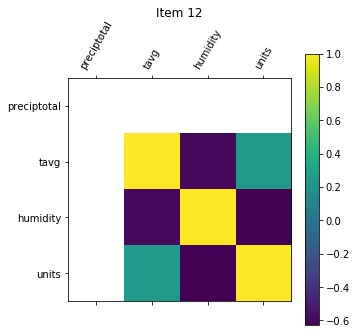

In [11]:
for correlation_tuple in high_correlation:
    item_id = correlation_tuple[0]
    corr = correlation_tuple[3]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    title = 'Item ' + str(int(item_id))  
    ax.set_title(title, pad=50)
    
    mappable = ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=60);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(mappable)

## <font color=grey>Scatterplot</font>

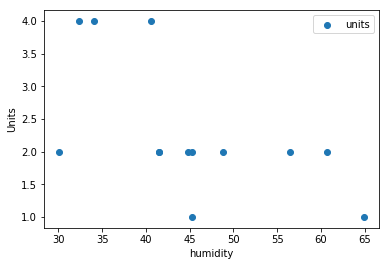

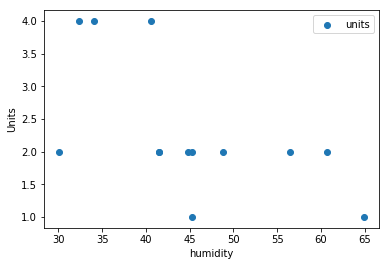

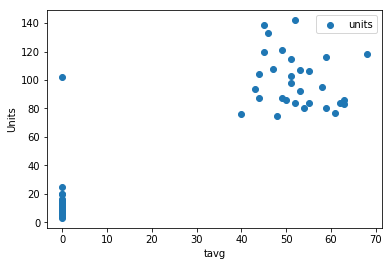

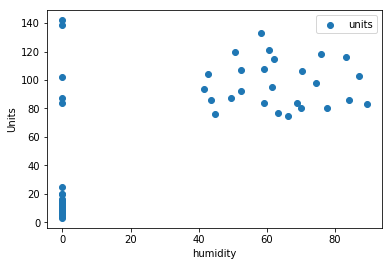

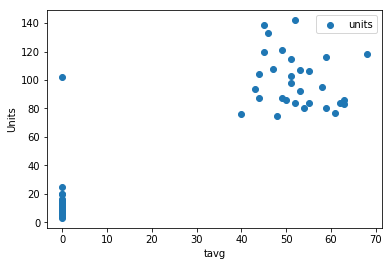

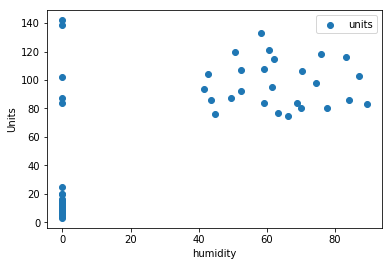

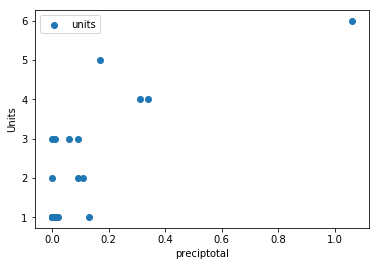

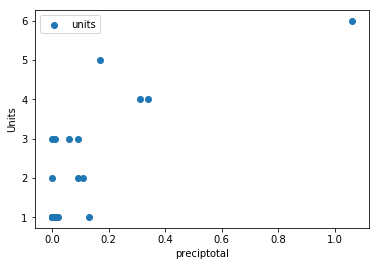

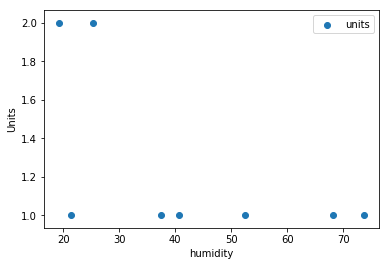

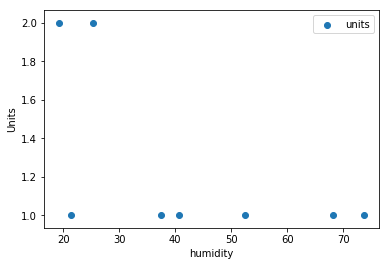

In [12]:
for correlation_tuple in high_correlation:
    item_id = correlation_tuple[0]
    column_a = correlation_tuple[1]
    column_b = correlation_tuple[2]
    df_corr = df_new[df_new['item_nbr'] == item_id]
    if column_a == 'units':
        x = df_corr[column_b]
        y = df_corr[column_a]
        x_label = column_b
    else:
        x = df_corr[column_a]
        y = df_corr[column_b]
        x_label = column_a
    plt.scatter(x, y)
    y_label = 'Units'
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    # plt.grid(True)
    plt.legend()
    plt.show()

# Sales Trend

## <font color=grey>Overall Item Sales</font>

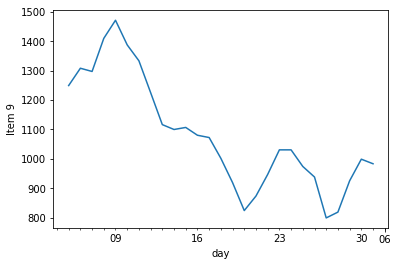

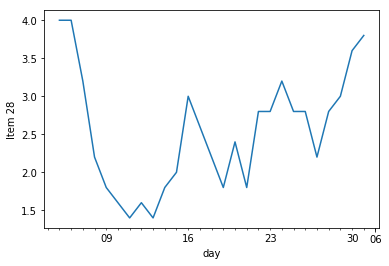

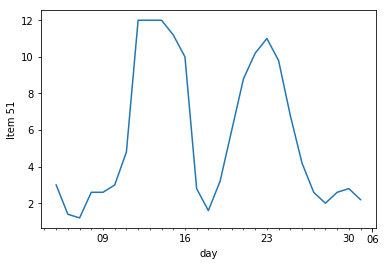

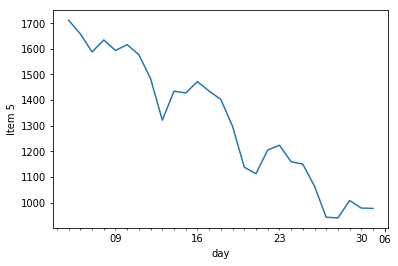

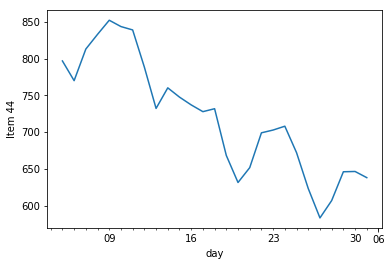

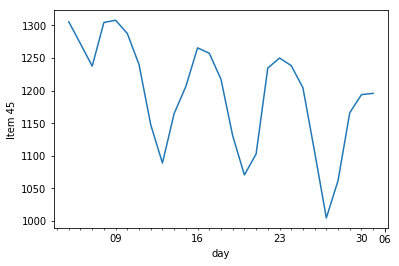

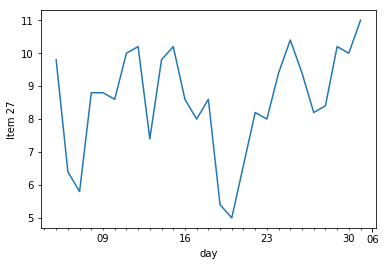

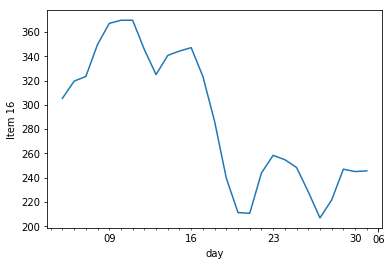

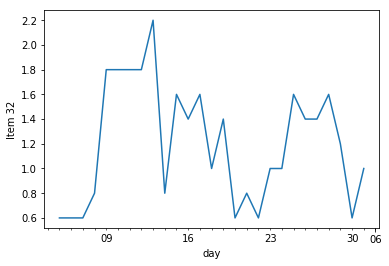

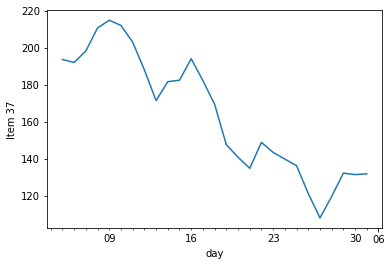

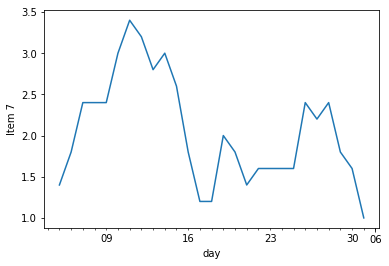

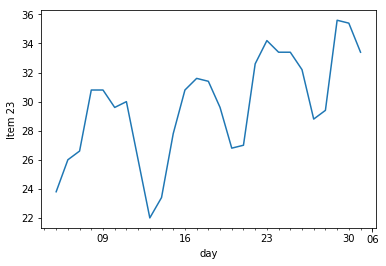

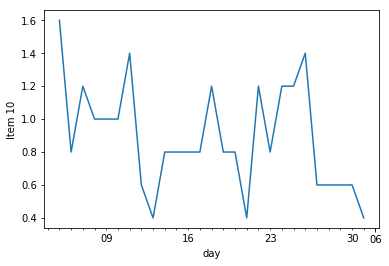

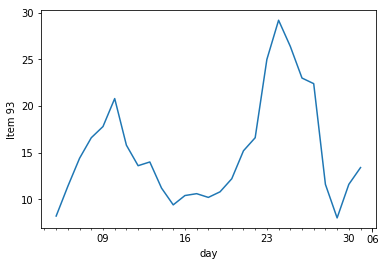

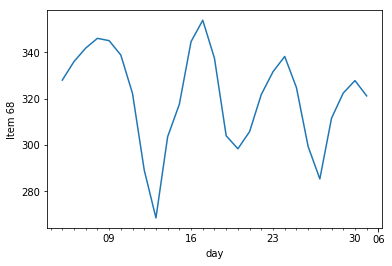

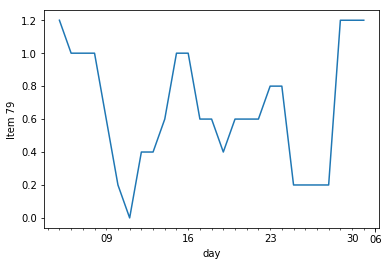

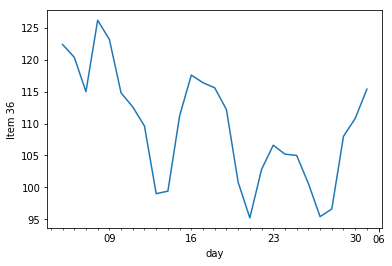

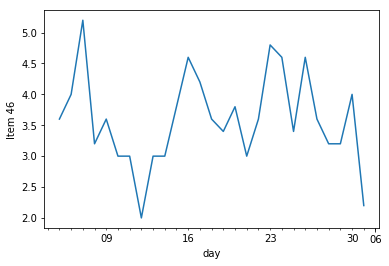

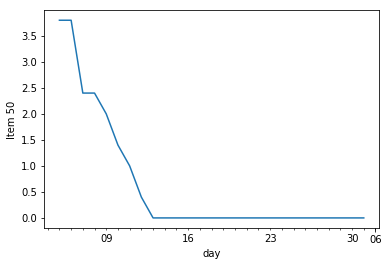

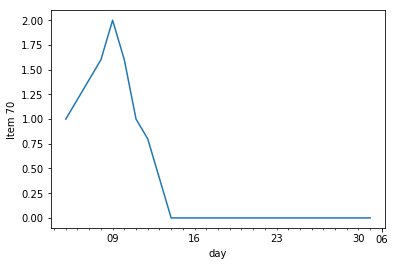

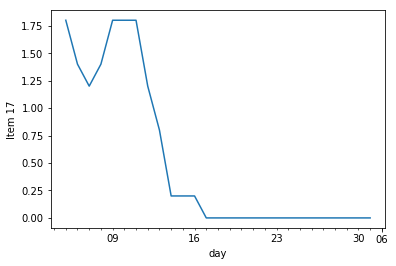

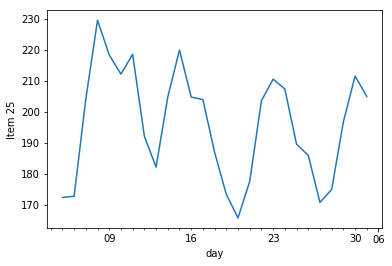

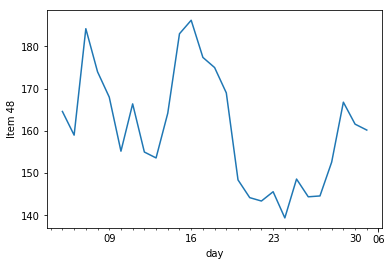

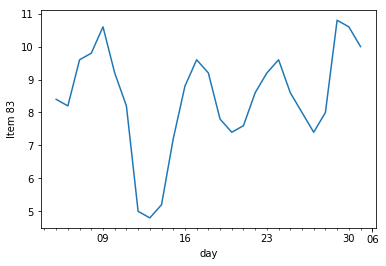

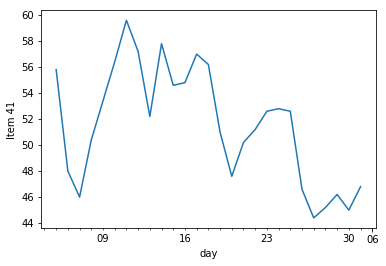

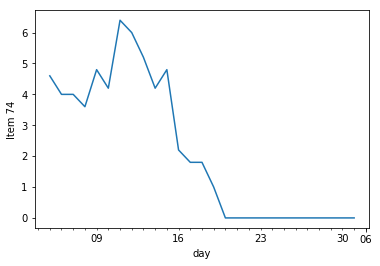

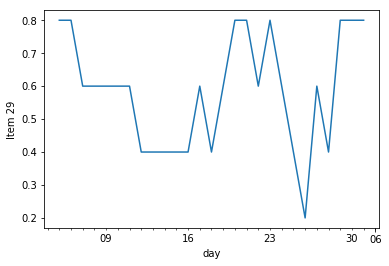

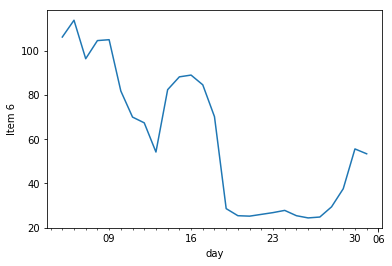

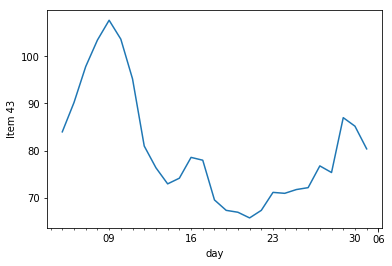

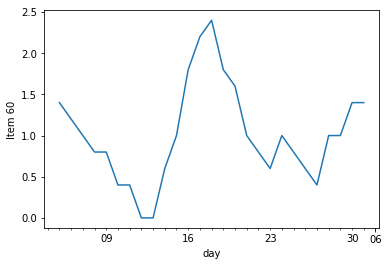

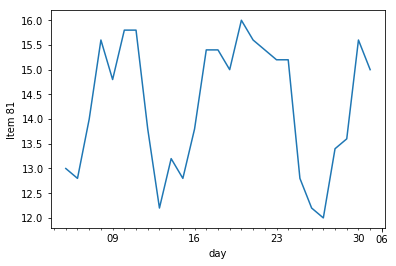

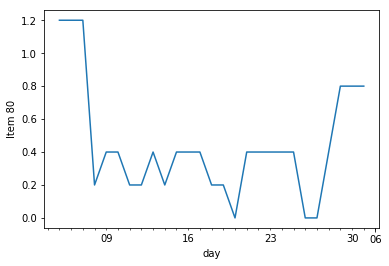

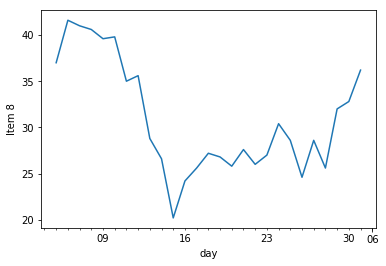

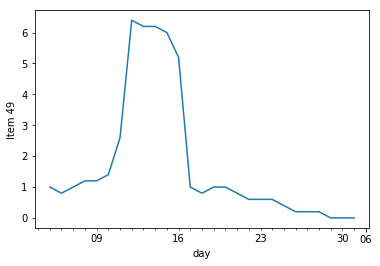

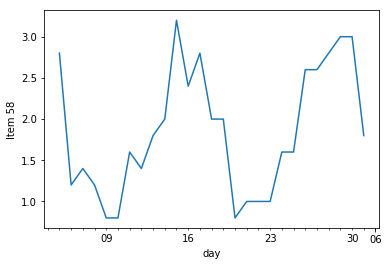

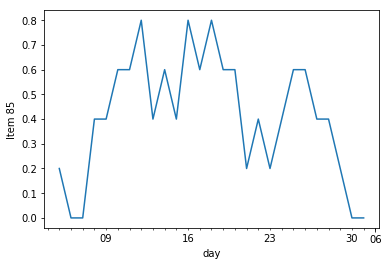

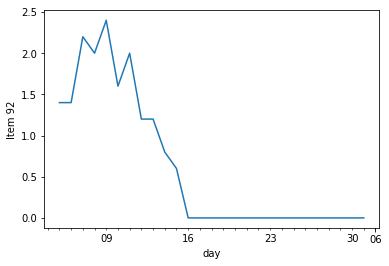

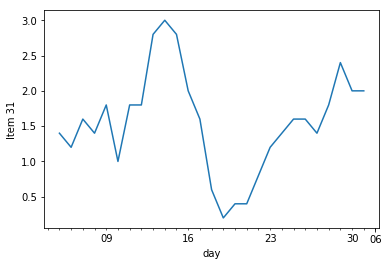

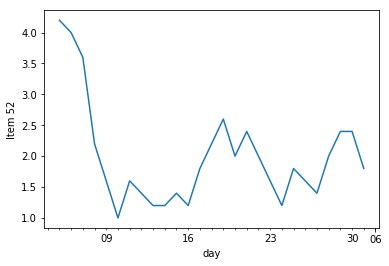

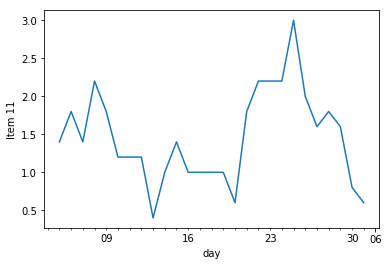

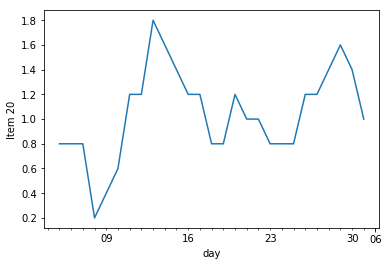

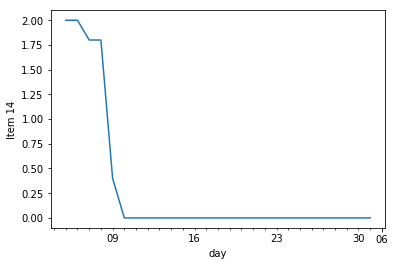

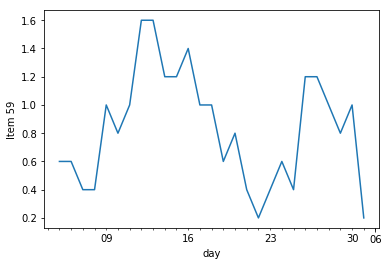

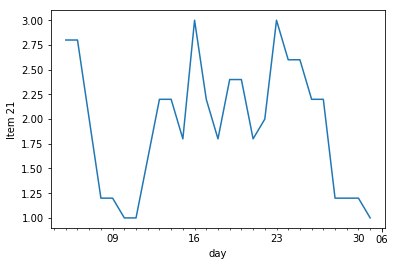

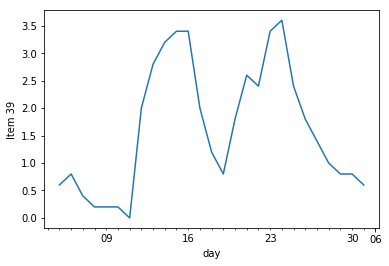

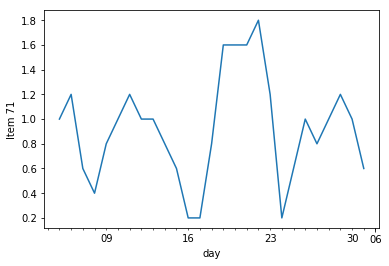

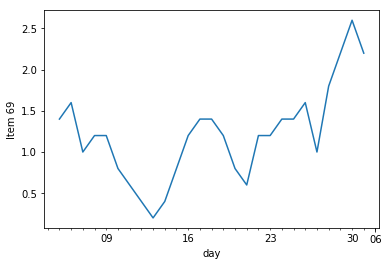

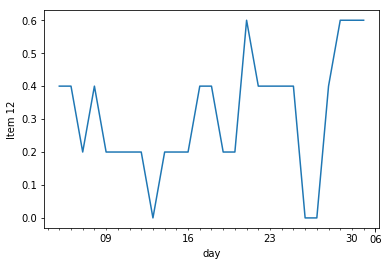

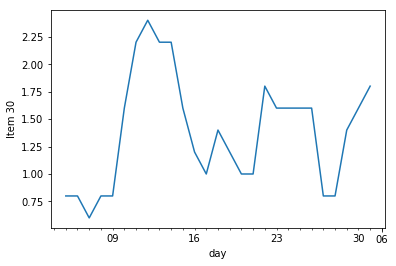

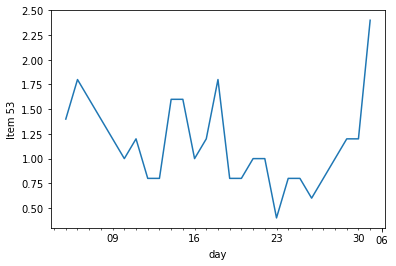

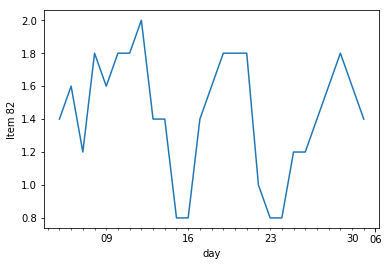

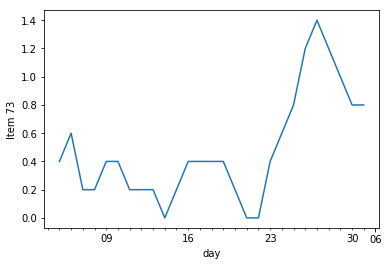

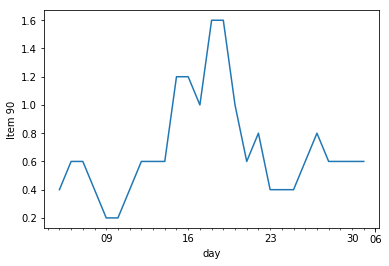

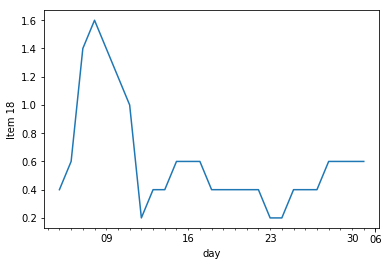

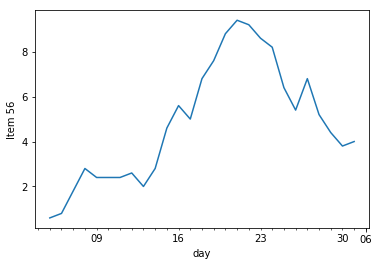

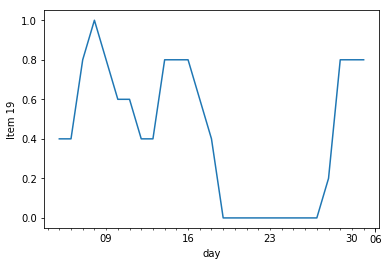

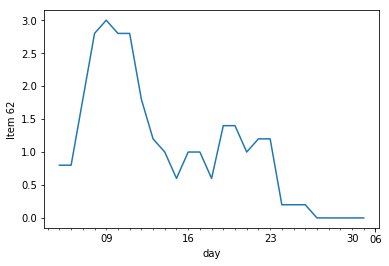

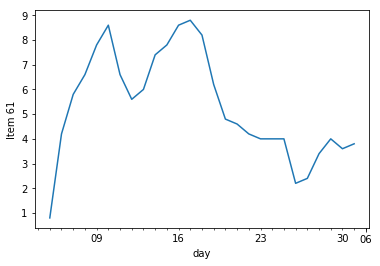

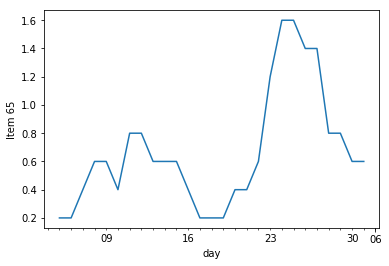

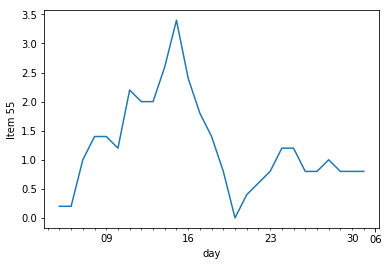

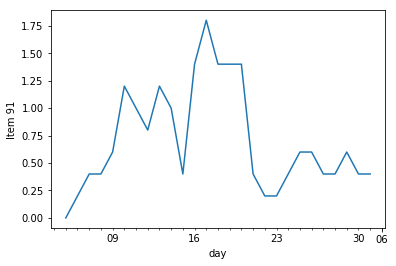

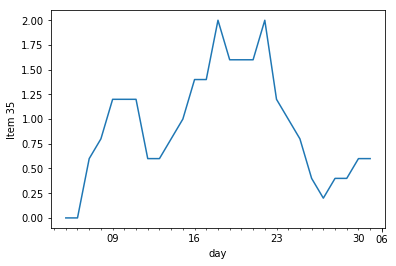

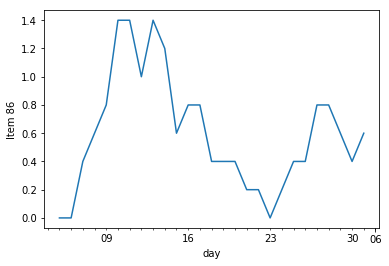

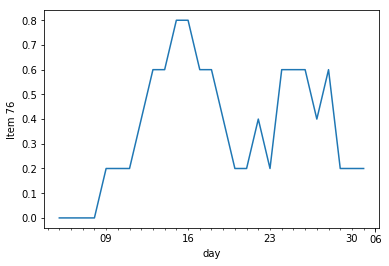

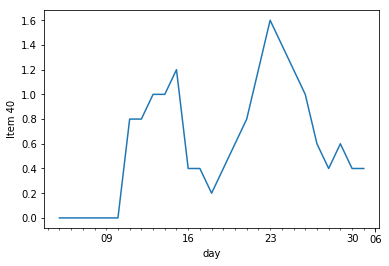

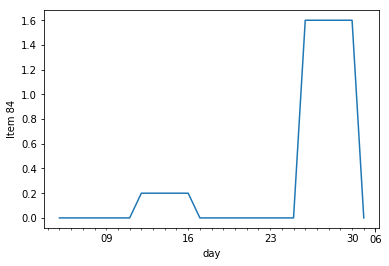

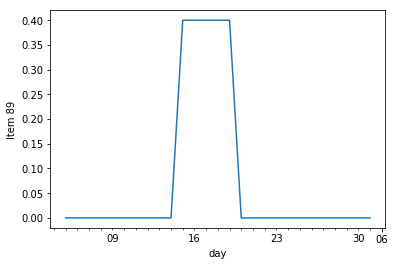

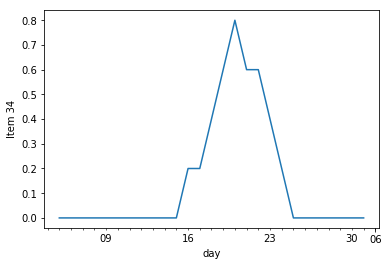

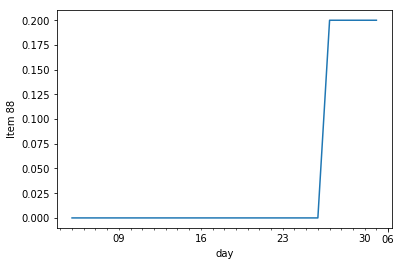

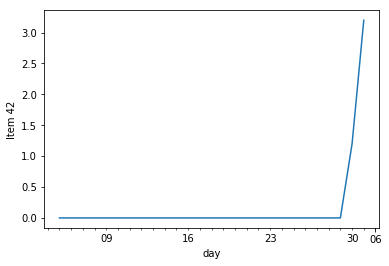

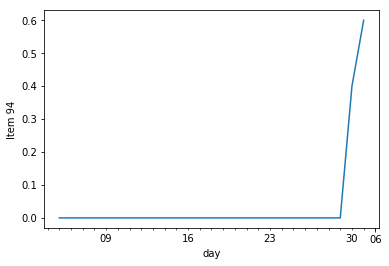

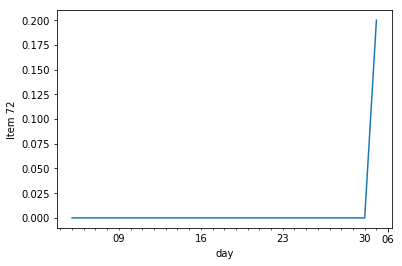

In [13]:
feature_columns = ['date', 'units']
holidays = ['1/2/2012', '1/16/2012']
for item_id in items:
    trend_df = df[df['item_nbr'] == item_id]
    trend_df = trend_df[feature_columns]
    if trend_df.shape[0] > 0:
        if (trend_df['units'] == 0).all() == False:
            trend_df.fillna(0, inplace=True)
            trend_df.rename(index=str, columns={"date": "day"}, inplace=True)
            trend_df['day'] =  pd.to_datetime(trend_df['day'], format='%m/%d/%Y')
            trend_series = trend_df.groupby('day')['units'].agg('sum')
            trend_df = trend_series.to_frame()
            
            # moving average
            trend_df['units'] = trend_df['units'].rolling(window=5).mean()
            trend_df.dropna(inplace=True)
            
            y_label = 'Item ' + str(int(item_id))
            plt.ylabel(y_label)
            plt.grid(True)
            ax = trend_df['units'].plot()
            ticklabels = trend_df.index.strftime('%d')
            ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
            plt.show()